In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import Dataset, DataLoader
import torchaudio
from torch.optim import AdamW
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve
from sklearn.utils import resample
from tqdm.notebook import tqdm
import gc # Garbage collector

2025-11-08 15:54:08.296961: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762617248.484279      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762617248.537214      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
# --- Configuration ---
DATASET_PATH = "/kaggle/input/asvspoof2019-la/LA"
PROTOCOLS_PATH = os.path.join(DATASET_PATH, "ASVspoof2019_LA_cm_protocols")
AUDIO_DIRS = {
    "train": os.path.join(DATASET_PATH, "ASVspoof2019_LA_train/flac"),
    "dev": os.path.join(DATASET_PATH, "ASVspoof2019_LA_dev/flac"),
    "eval": os.path.join(DATASET_PATH, "ASVspoof2019_LA_eval/flac"),
}
PROTOCOL_FILES = {
    "train": os.path.join(PROTOCOLS_PATH, "ASVspoof2019.LA.cm.train.trn.txt"),
    "dev": os.path.join(PROTOCOLS_PATH, "ASVspoof2019.LA.cm.dev.trl.txt"),
    "eval": os.path.join(PROTOCOLS_PATH, "ASVspoof2019.LA.cm.eval.trl.txt"),
}
MODEL_SAVE_PATH = "/kaggle/working/" # Or "./" if running locally
BEST_MODEL_NAME = "wav2vec2_deepfake_best.pt"
FINAL_MODEL_NAME = "wav2vec2_deepfake_final.pt"


In [3]:
# Model & Training Hyperparameters
MODEL_IDENTIFIER = "facebook/wav2vec2-xls-r-300m"
TARGET_SAMPLE_RATE = 16000 # XLS-R also expects 16kHz
MAX_AUDIO_SECONDS = 5 # Max duration to process
MAX_LENGTH = TARGET_SAMPLE_RATE * MAX_AUDIO_SECONDS

BATCH_SIZE = 16 # Adjust based on GPU memory (XLS-R might require slightly more memory)
EPOCHS = 15 # Initial training epochs
LEARNING_RATE = 5e-4
FINETUNE_EPOCHS = 3
FINETUNE_LR = 2e-5 # Fine-tuning LR might need adjustment for XLS-R
EARLY_STOPPING_PATIENCE = 5
NUM_WORKERS = 4 # Number of parallel data loading workers

In [4]:
# Data Balancing
SAMPLES_PER_CLASS_TRAIN = 5000
SAMPLES_PER_CLASS_DEV_EVAL = 1250

# Determine device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")
print(f"Using model: {MODEL_IDENTIFIER}")

# Create output directory if it doesn't exist
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

Using device: cuda
Using model: facebook/wav2vec2-xls-r-300m


In [5]:
# --- 1. Load Protocol Data & Stratified Splitting and Sampling ---
def load_protocol(protocol_path, audio_dir):
    """Loads protocol and adds full file paths, including Spoof_Type."""
    try:
        # Check if protocol file exists
        if not os.path.exists(protocol_path):
             print(f"Error: Protocol file not found at {protocol_path}")
             return pd.DataFrame(columns=["Speaker_ID", "File_ID", "-", "Spoof_Type", "Label"])

        df = pd.read_csv(protocol_path, sep=" ", header=None,
                         names=["Speaker_ID", "File_ID", "-", "Spoof_Type", "Label"])
        # Keep Spoof_Type for stratification
        df = df[["File_ID", "Spoof_Type", "Label"]]
        df["Label"] = df["Label"].map({"bonafide": 1, "spoof": 0}) # 1 for real, 0 for fake

        df['filepath'] = df['File_ID'].apply(lambda x: os.path.join(audio_dir, x + '.flac'))

        # Filter out files that don't exist
        original_count = len(df)
        df = df[df['filepath'].apply(os.path.exists)].reset_index(drop=True)
        filtered_count = len(df)
        if original_count != filtered_count:
            print(f"Warning: {original_count - filtered_count} files not found for {os.path.basename(protocol_path)}.")

        print(f"Loaded {os.path.basename(protocol_path)}: {len(df)} samples total "
              f"({len(df[df['Label']==1])} real, {len(df[df['Label']==0])} fake)")
        return df

    except FileNotFoundError: # Should be caught by os.path.exists, but keep as fallback
        print(f"Error: Protocol file not found at {protocol_path}")
        return pd.DataFrame(columns=["File_ID", "Spoof_Type", "Label", "filepath"])
    except Exception as e:
        print(f"Error loading protocol {protocol_path}: {e}")
        return pd.DataFrame(columns=["File_ID", "Spoof_Type", "Label", "filepath"])


def stratified_sample(df, target_samples, stratify_col, random_state=42):
    """
    Performs stratified sampling on a dataframe.
    Samples proportionally from each group defined by stratify_col,
    taking all samples if a group is smaller than its target proportion.
    """
    if df.empty or target_samples <= 0:
        print("Warning: Cannot sample from empty dataframe or with non-positive target samples.")
        return pd.DataFrame(columns=df.columns)

    # Handle potential missing 'Spoof_Type' values for stratification
    df['_Stratify_Helper'] = df[stratify_col].fillna('Bonafide')

    group_counts = df['_Stratify_Helper'].value_counts()
    total_samples_in_df = len(df)

    sampled_df = pd.DataFrame(columns=df.columns)

    for group_name, count in group_counts.items():
        # Calculate the target number of samples for this group
        # Ensure we don't request more samples than are available in the group
        target_group_samples = min(count, int(np.ceil((count / total_samples_in_df) * target_samples)))

        if target_group_samples > 0:
            # Sample from the current group
            group_df = df[df['_Stratify_Helper'] == group_name]
            sampled_group = group_df.sample(n=target_group_samples, random_state=random_state, replace=False)
            sampled_df = pd.concat([sampled_df, sampled_group], ignore_index=True)
        else:
             print(f"Warning: Skipping sampling for group '{group_name}' as target is 0.")


    # Clean up helper column
    sampled_df = sampled_df.drop(columns=['_Stratify_Helper'])
    df = df.drop(columns=['_Stratify_Helper']) # Drop from original df too

    print(f"Sampled {len(sampled_df)} samples (target was {target_samples}).")
    return sampled_df

print("Loading full protocols for splitting and sampling...")
# Check if base path exists (useful feedback in Kaggle)
if not os.path.exists(DATASET_PATH):
    print(f"Warning: Base data path not found at {DATASET_PATH}. Check dataset mounting.")
if not os.path.exists(PROTOCOLS_PATH):
     print(f"Warning: Protocols path not found at {PROTOCOLS_PATH}.")


# Load full protocols for each set initially
df_train_full = load_protocol(PROTOCOL_FILES["train"], AUDIO_DIRS["train"])
df_dev_full = load_protocol(PROTOCOL_FILES["dev"], AUDIO_DIRS["dev"])
df_eval_full = load_protocol(PROTOCOL_FILES["eval"], AUDIO_DIRS["eval"])


# --- Perform Stratified Sampling ---
TARGET_TRAIN_SAMPLES = 10000
TARGET_DEV_SAMPLES = 1250
TARGET_EVAL_SAMPLES = 1250


print(f"\nSampling {TARGET_TRAIN_SAMPLES} training samples (stratified)...")
df_train = stratified_sample(df_train_full, TARGET_TRAIN_SAMPLES, 'Spoof_Type')

print(f"\nSampling {TARGET_DEV_SAMPLES} development samples (stratified)...")
df_dev = stratified_sample(df_dev_full, TARGET_DEV_SAMPLES, 'Spoof_Type')

print(f"\nSampling {TARGET_EVAL_SAMPLES} evaluation samples (stratified)...")
df_eval = stratified_sample(df_eval_full, TARGET_EVAL_SAMPLES, 'Spoof_Type')


# --- Check if dataframes are empty ---
if df_train.empty or df_dev.empty or df_eval.empty:
    raise ValueError("One or more dataframes (train, dev, eval) are empty after sampling. Check data paths and sampling logic.")

print("\nTrain dataset distribution (after sampling):")
print(df_train['Label'].value_counts())
print("\nDev dataset distribution (after sampling):")
print(df_dev['Label'].value_counts())
print("\nEval dataset distribution (after sampling):")
print(df_eval['Label'].value_counts())

# Verify Spoof_Type distribution in sampled splits
print("\nTrain dataset Spoof_Type distribution (after sampling):")
print(df_train['Spoof_Type'].value_counts())
print("\nDev dataset Spoof_Type distribution (after sampling):")
print(df_dev['Spoof_Type'].value_counts())
print("\nEval dataset Spoof_Type distribution (after sampling):")
print(df_eval['Spoof_Type'].value_counts())


# Clean up original full dataframes
del df_train_full, df_dev_full, df_eval_full
gc.collect()
if DEVICE.type == 'cuda': torch.cuda.empty_cache()

Loading full protocols for splitting and sampling...
Loaded ASVspoof2019.LA.cm.train.trn.txt: 25380 samples total (2580 real, 22800 fake)
Loaded ASVspoof2019.LA.cm.dev.trl.txt: 24844 samples total (2548 real, 22296 fake)
Loaded ASVspoof2019.LA.cm.eval.trl.txt: 71237 samples total (7355 real, 63882 fake)

Sampling 10000 training samples (stratified)...
Sampled 10005 samples (target was 10000).

Sampling 1250 development samples (stratified)...
Sampled 1251 samples (target was 1250).

Sampling 1250 evaluation samples (stratified)...
Sampled 1261 samples (target was 1250).

Train dataset distribution (after sampling):
Label
0    8988
1    1017
Name: count, dtype: int64

Dev dataset distribution (after sampling):
Label
0    1122
1     129
Name: count, dtype: int64

Eval dataset distribution (after sampling):
Label
0    1131
1     130
Name: count, dtype: int64

Train dataset Spoof_Type distribution (after sampling):
Spoof_Type
A01    1498
A02    1498
A03    1498
A05    1498
A04    1498
A06 

In [6]:
# --- Calculate Class Weights for Training Set ---
print("\nCalculating class weights for training set...")
class_counts = df_train['Label'].value_counts().sort_index()
if len(class_counts) == 2: # Ensure both classes are present
    total_samples = len(df_train)
    weight_for_0 = total_samples / (2.0 * class_counts[0])
    weight_for_1 = total_samples / (2.0 * class_counts[1])
    class_weights = torch.tensor([weight_for_0, weight_for_1], dtype=torch.float)
    print(f"Class weights: {class_weights}")
    class_weights = class_weights.to(DEVICE) # Move weights to the correct device
else:
    print("Warning: Training data does not contain both classes. Cannot calculate weights.")
    class_weights = None # Handle this case in criterion initialization



Calculating class weights for training set...
Class weights: tensor([0.5566, 4.9189])


In [7]:
# --- 2. PyTorch Dataset ---
class AudioDataset(Dataset):
    """PyTorch Dataset for loading and processing audio files."""
    def __init__(self, dataframe, feature_extractor, target_sr=TARGET_SAMPLE_RATE, max_length=MAX_LENGTH):
        self.df = dataframe
        self.feature_extractor = feature_extractor # Use feature_extractor
        self.target_sr = target_sr
        self.max_length = max_length
        # Pre-create resampler if target_sr is fixed
        self.resampler_cache = {}

    def __len__(self):
        return len(self.df)

    def _get_resampler(self, orig_freq, new_freq):
        """Cache resamplers to avoid recreating them repeatedly."""
        if (orig_freq, new_freq) not in self.resampler_cache:
            self.resampler_cache[(orig_freq, new_freq)] = torchaudio.transforms.Resample(orig_freq=orig_freq, new_freq=new_freq)
        return self.resampler_cache[(orig_freq, new_freq)]

    def __getitem__(self, idx):
        if idx >= len(self.df):
             raise IndexError("Index out of bounds")

        row = self.df.iloc[idx]
        audio_path = row['filepath']
        label = row['Label']

        try:
            waveform, sample_rate = torchaudio.load(audio_path)

            if waveform.shape[0] > 1:
                waveform = torch.mean(waveform, dim=0, keepdim=True)

            if sample_rate != self.target_sr:
                # Use functional resampling which might be slightly faster without caching object
                waveform = torchaudio.functional.resample(waveform, orig_freq=sample_rate, new_freq=self.target_sr)
                # Or use cached resampler:
                # resampler = self._get_resampler(sample_rate, self.target_sr)
                # waveform = resampler(waveform)


            # Truncate or pad waveform
            if waveform.shape[1] > self.max_length:
                waveform = waveform[:, :self.max_length]
            # Padding is handled by the feature extractor's __call__ method

            # Process using the feature extractor
            # Squeeze to remove channel dimension for feature extractor if it's mono
            inputs = self.feature_extractor(
                waveform.squeeze(0),
                sampling_rate=self.target_sr,
                return_tensors="pt",
                padding="max_length", # Pad to a consistent length (model's max or specified max)
                max_length=self.max_length, # Use the same max length for padding
                truncation=True # Ensure truncation if somehow still longer after manual truncate
            )

            # The feature extractor output is nested, get the input_values tensor
            input_values = inputs.input_values.squeeze(0) # Remove batch dim added by feature_extractor

            return {"input_values": input_values, "labels": torch.tensor(label, dtype=torch.long)}

        except Exception as e:
            print(f"Error processing file {audio_path} at index {idx}: {e}")
            # Return None or raise error, or return a dummy sample
            # Returning dummy sample to avoid crashing the loader entirely
            # Adjust dummy shape based on expected feature extractor output if needed
            dummy_input = torch.zeros(self.max_length) # Adjust size if needed
            # Need to process the dummy input to get the correct shape after feature extraction
            dummy_processed = self.feature_extractor(dummy_input, sampling_rate=self.target_sr, return_tensors="pt", padding="max_length", max_length=self.max_length, truncation=True)
            return {"input_values": dummy_processed.input_values.squeeze(0), "labels": torch.tensor(-1, dtype=torch.long)} # Use -1 label for errors


In [8]:
# --- 3. Initialize Processor and Create Datasets/DataLoaders ---
print(f"Initializing processor for {MODEL_IDENTIFIER}...")
# Load only the feature extractor
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(
    MODEL_IDENTIFIER,
    sampling_rate=TARGET_SAMPLE_RATE # Ensure target sample rate is set
)
print("Creating datasets...")
train_dataset = AudioDataset(df_train, feature_extractor, TARGET_SAMPLE_RATE,MAX_LENGTH)
dev_dataset = AudioDataset(df_dev, feature_extractor, TARGET_SAMPLE_RATE,MAX_LENGTH)
eval_dataset = AudioDataset(df_eval, feature_extractor, TARGET_SAMPLE_RATE,MAX_LENGTH)

# Custom collate function to handle potential errors from __getitem__
def collate_fn(batch):
    batch = [item for item in batch if item is not None and item["labels"] != -1]
    if not batch:
        return None
    try:
        input_values = torch.stack([item["input_values"] for item in batch])
        labels = torch.stack([item["labels"] for item in batch])
        return {
            "input_values": input_values,
            "labels": labels
        }
    except Exception as e:
        print(f"Error during collation: {e}")
        return None


print("Creating data loaders...")
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS,
                          collate_fn=collate_fn, pin_memory=True, persistent_workers=(NUM_WORKERS > 0))
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS,
                        collate_fn=collate_fn, pin_memory=True, persistent_workers=(NUM_WORKERS > 0))
eval_loader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS,
                         collate_fn=collate_fn, pin_memory=True, persistent_workers=(NUM_WORKERS > 0))

print(f"Train loader batches approx: {len(train_loader)}")
print(f"Dev loader batches approx: {len(dev_loader)}")
print(f"Eval loader batches approx: {len(eval_loader)}")


Initializing processor for facebook/wav2vec2-xls-r-300m...


preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

Creating datasets...
Creating data loaders...
Train loader batches approx: 626
Dev loader batches approx: 79
Eval loader batches approx: 79


In [9]:
# --- 4. Model Definition ---
class XLSRClassificationModel(nn.Module):
    """XLS-R model (Wav2Vec2 architecture) with a classification head."""
    def __init__(self, model_identifier=MODEL_IDENTIFIER, num_labels=2, dropout_prob=0.1):
        super().__init__()
        print(f"Loading pre-trained model: {model_identifier}")
        # Load the pretrained XLS-R base model using Wav2Vec2Model class
        self.xlsr = Wav2Vec2Model.from_pretrained(model_identifier) # <<< Uses updated identifier

        # --- Freeze the encoder initially ---
        self.freeze_encoder() # Call freeze method here

        # Get the hidden size from the model config
        self.hidden_size = self.xlsr.config.hidden_size
        print(f"Model hidden size: {self.hidden_size}")

        # Define the classification head
        self.classifier = nn.Sequential(
            nn.Linear(self.xlsr.config.hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(256, num_labels)
        )
        self.attention_weights_layer = nn.Sequential(
            nn.Linear(self.hidden_size, 128), # Project hidden state
            nn.Tanh(),                     # Activation
            nn.Linear(128, 1)              # Output one score per time step
        )
        self.num_labels = num_labels

    def freeze_encoder(self):
        """Freezes all layers in the feature encoder."""
        print("Freezing encoder layers...")
        if hasattr(self.xlsr, 'feature_extractor'): # Older Wav2Vec2 structure
             for param in self.xlsr.feature_extractor.parameters():
                 param.requires_grad = False
        if hasattr(self.xlsr, 'feature_projection'): # Newer structure / Conv Layers
             for param in self.xlsr.feature_projection.parameters():
                 param.requires_grad = False
        if hasattr(self.xlsr, 'encoder'): # Transformer blocks
            for param in self.xlsr.encoder.parameters():
                param.requires_grad = False
        print("Encoder layers frozen.")

    def unfreeze_encoder(self, num_layers=None):
        """Unfreezes the top 'num_layers' of the transformer encoder."""
        if not hasattr(self.xlsr, 'encoder') or not hasattr(self.xlsr.encoder, 'layers'):
             print("Warning: Model structure does not match expected 'encoder.layers'. Cannot unfreeze specific layers.")
             # Optionally unfreeze the whole encoder if structure is different
             # for param in self.xlsr.encoder.parameters():
             #    param.requires_grad = True
             return

        if num_layers is None: # Unfreeze all encoder layers
            print(f"Unfreezing ALL {len(self.xlsr.encoder.layers)} encoder layers...")
            for param in self.xlsr.encoder.parameters():
                 param.requires_grad = True
        elif num_layers > 0:
             total_layers = len(self.xlsr.encoder.layers)
             layers_to_unfreeze = min(num_layers, total_layers)
             print(f"Unfreezing the top {layers_to_unfreeze} encoder layers...")
             # Unfreeze the specified top layers
             for i in range(total_layers - layers_to_unfreeze, total_layers):
                 for param in self.xlsr.encoder.layers[i].parameters():
                     param.requires_grad = True
        else:
             print("No encoder layers specified to unfreeze (num_layers=0 or None). Keeping frozen.")

        # Optional: Verify which layers are unfrozen
        # for name, param in self.xlsr.encoder.named_parameters():
        #     if param.requires_grad:
        #         print(f"  - Unfrozen: {name}")


    def forward(self, input_values, attention_mask=None):
        # Pass data through base XLS-R model
        outputs = self.xlsr(input_values=input_values, attention_mask=attention_mask)

        # Use the hidden states from the last layer
        last_hidden_state = outputs.last_hidden_state

         # --- Replace Mean Pooling with Attention Pooling ---
        # Calculate attention scores
        attention_logits = self.attention_weights_layer(last_hidden_state).squeeze(-1) # Shape: [batch, seq_len]

        # Apply mask before softmax (mask has 1 for real tokens, 0 for padding)
        if attention_mask is not None:
            # Set scores for padding tokens to a very large negative number
            attention_logits = attention_logits.masked_fill(attention_mask == 0, -1e9)

        # Calculate attention weights
        attention_weights = nn.functional.softmax(attention_logits, dim=1) # Shape: [batch, seq_len]

        # Calculate weighted sum (attention pooling)
        # Unsqueeze weights to match hidden state dims for broadcasting: [batch, seq_len, 1]
        pooled_output = torch.sum(last_hidden_state * attention_weights.unsqueeze(-1), dim=1)
        # Shape: [batch, hidden_size]
        # --- End Replacement ---


        # Pass the pooled output through the classifier
        logits = self.classifier(pooled_output)
        return logits

In [10]:
# --- 5. EER Calculation ---
def calculate_eer(y_true, y_scores):
    """Calculates the Equal Error Rate (EER)"""
    y_true = np.asarray(y_true)
    y_scores = np.asarray(y_scores)
    if len(np.unique(y_true)) < 2:
        return float('nan'), float('nan')
    fpr, tpr, thresholds = roc_curve(y_true, y_scores, pos_label=1)
    fnr = 1 - tpr
    eer_threshold_idx = np.nanargmin(np.abs(fpr - fnr))
    if eer_threshold_idx < len(fpr) and eer_threshold_idx < len(fnr):
        eer = (fpr[eer_threshold_idx] + fnr[eer_threshold_idx]) / 2.0
        eer_threshold = thresholds[eer_threshold_idx]
        return eer, eer_threshold
    else:
        print("Warning: Could not determine EER threshold index.")
        return float('nan'), float('nan')

In [11]:
# --- 6. Training and Evaluation Functions ---
from sklearn.metrics import roc_auc_score # Import AUC calculation
import sys
# Remove dependency on asvspoof-toolkit support_measure

def calculate_eer(y_true, y_scores):
    """Calculates the Equal Error Rate (EER)"""
    y_true = np.asarray(y_true)
    y_scores = np.asarray(y_scores)
    if len(np.unique(y_true)) < 2:
        return float('nan'), float('nan')
    fpr, tpr, thresholds = roc_curve(y_true, y_scores, pos_label=1)
    fnr = 1 - tpr
    eer_threshold_idx = np.nanargmin(np.abs(fpr - fnr))
    if eer_threshold_idx < len(fpr) and eer_threshold_idx < len(fnr):
        eer = (fpr[eer_threshold_idx] + fnr[eer_threshold_idx]) / 2.0
        eer_threshold = thresholds[eer_threshold_idx]
        return eer, eer_threshold
    else:
        print("Warning: Could not determine EER threshold index.")
        return float('nan'), float('nan')

def calculate_tdcf(y_true, y_scores, p_bona=0.5, p_spoof=0.5, c_miss=1, c_fa=1):
    """
    Calculates the minimum t-DCF for a given set of scores and labels.
    Implemented based on ASVspoof challenge evaluation plan.

    Args:
        y_true (np.ndarray): True labels (1 for bonafide, 0 for spoof).
        y_scores (np.ndarray): Predicted scores (higher for bonafide).
        p_bona (float): Prior probability of bonafide samples.
        p_spoof (float): Prior probability of spoof samples.
        c_miss (float): Cost of a miss (false rejection of bonafide).
        c_fa (float): Cost of a false alarm (false acceptance of spoof).

    Returns:
        float: The minimum t-DCF value.
    """
    y_true = np.asarray(y_true)
    y_scores = np.asarray(y_scores)

    # Ensure there are both bonafide and spoof samples
    if len(np.unique(y_true)) < 2:
        print("Warning: Cannot calculate t-DCF - only one true class present.")
        return float('nan')

    # Sort scores and corresponding labels
    indices = np.argsort(y_scores)
    y_scores_sorted = y_scores[indices]
    y_true_sorted = y_true[indices]

    n_bona = np.sum(y_true == 1)
    n_spoof = np.sum(y_true == 0)

    if n_bona == 0 or n_spoof == 0:
         print("Warning: Cannot calculate t-DCF - no bonafide or no spoof samples.")
         return float('nan')

    # Initialize t-DCF to a large value
    min_tdcf = float('inf')

    # Iterate through all possible thresholds (scores)
    # Using unique sorted scores as potential thresholds
    unique_scores = np.unique(y_scores_sorted)
    for threshold in unique_scores:
        # Classify samples based on the current threshold
        # Samples with score >= threshold are predicted as bonafide (1)
        # Samples with score < threshold are predicted as spoof (0)
        y_pred = (y_scores_sorted >= threshold).astype(int)

        # Calculate False Alarm Rate (FAR) and False Rejection Rate (FRR)
        # FAR: Proportion of spoof samples incorrectly classified as bonafide (0 -> 1)
        # FRR: Proportion of bonafide samples incorrectly classified as spoof (1 -> 0)
        fa = np.sum((y_true_sorted == 0) & (y_pred == 1))
        miss = np.sum((y_true_sorted == 1) & (y_pred == 0))

        far = fa / n_spoof
        frr = miss / n_bona

        # Calculate t-DCF for the current threshold
        tdcf = c_miss * frr * p_bona + c_fa * far * p_spoof

        # Update minimum t-DCF
        if tdcf < min_tdcf:
            min_tdcf = tdcf

    # Normalize minimum t-DCF by the minimum possible t-DCF
    # The minimum possible t-DCF is achieved by a perfect system (FAR=0, FRR=0)
    # Normalized t-DCF = min_tdcf / min(c_miss * p_bona, c_fa * p_spoof)
    # A perfect system would have costs: c_miss * 0 * p_bona + c_fa * 0 * p_spoof = 0
    # However, the standard normalization is against a system that always outputs bonafide or always outputs spoof.
    # The denominator is min(c_miss * p_bona, c_fa * p_spoof)
    denominator = min(c_miss * p_bona, c_fa * p_spoof)
    if denominator == 0:
         print("Warning: Denominator for normalized t-DCF is zero. Returning unnormalized t-DCF.")
         return min_tdcf # Return unnormalized if denominator is zero

    normalized_min_tdcf = min_tdcf / denominator

    return normalized_min_tdcf


def evaluate(model, data_loader, criterion, device, return_tdcf=False): # Removed tdcf file paths
    """Evaluates the model on a given dataset."""
    model.eval()
    total_loss = 0.0
    num_samples = 0
    printed_batch_info = False # Flag to print only for the first batch
    with torch.no_grad():
        all_preds_probs = [] # Store probabilities for AUC, EER, and t-DCF
        all_labels = []
        progress_bar = tqdm(data_loader, desc="Evaluating", leave=False)
        for i, batch in enumerate(progress_bar): # Add enumerate to track batch index
            if batch is None: continue
            input_values = batch["input_values"].to(device, non_blocking=True)
            labels = batch["labels"].to(device, non_blocking=True).long()
            if input_values.size(0) == 0: continue

            with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                logits = model(input_values)
                loss = criterion(logits, labels)
            total_loss += loss.item() * input_values.size(0)
            num_samples += input_values.size(0)
            probabilities = torch.softmax(logits, dim=1)
            # We need the score for the BONAFIDE class (label 1) for EER and t-DCF
            positive_class_probs = probabilities[:, 1].cpu().numpy()
            all_preds_probs.extend(positive_class_probs)
            all_labels.extend(labels.cpu().numpy())

            # --- Add Diagnostic Print ---
            if not printed_batch_info and i == 0: # Print for the first batch only
                print("\n--- Evaluation Batch 0 Diagnostics ---")
                print(f"Labels (first 10): {labels[:10].cpu().numpy()}")
                print(f"Logits (first 5): \n{logits[:5].cpu().numpy()}")
                print(f"Probabilities (first 5): \n{probabilities[:5].cpu().numpy()}")
                print(f"Positive Class Probs (first 10): {positive_class_probs[:10]}")
                # Add predicted binary labels for the first batch
                preds_binary_batch = (positive_class_probs > 0.5).astype(int)
                print(f"Predicted Binary (first 10): {preds_binary_batch[:10]}")
                print("--- End Diagnostics ---")
                printed_batch_info = True
            # --- End Diagnostic Print ---


    if num_samples == 0:
        if return_tdcf:
             return float('nan'), float('nan'), float('nan'), float('nan'), float('nan')
        else:
            return float('nan'), float('nan'), float('nan'), float('nan')

    avg_loss = total_loss / num_samples
    all_labels = np.array(all_labels)
    all_preds_probs = np.array(all_preds_probs)

    # Calculate EER
    eer, _ = calculate_eer(all_labels, all_preds_probs)

    # Calculate Accuracy (using a 0.5 threshold for binary prediction)
    preds_binary = (all_preds_probs > 0.5).astype(int)
    accuracy = np.mean(preds_binary == all_labels) if len(all_labels) > 0 else 0.0

    # Calculate AUC
    try:
        if len(np.unique(all_labels)) > 1:
             auc_score = roc_auc_score(all_labels, all_preds_probs)
        else:
             print("Warning: Cannot calculate AUC - only one true class present in evaluation data.")
             auc_score = float('nan')
    except Exception as e:
        print(f"Error calculating AUC: {e}")
        auc_score = float('nan')

    if return_tdcf:
        # Calculate min t-DCF using the custom function
        min_tdcf = calculate_tdcf(all_labels, all_preds_probs)
        return avg_loss, accuracy, eer, auc_score, min_tdcf
    else:
        return avg_loss, accuracy, eer, auc_score


def train_epoch(model, data_loader, criterion, optimizer, scheduler, device, scaler):
    """Trains the model for one epoch."""
    model.train()
    total_loss = 0.0
    num_batches = 0
    progress_bar = tqdm(data_loader, desc="Training", leave=False)
    for batch in progress_bar:
        if batch is None: continue
        input_values = batch["input_values"].to(device, non_blocking=True)
        labels = batch["labels"].to(device, non_blocking=True).long()
        if input_values.size(0) == 0: continue

        optimizer.zero_grad()
        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
            logits = model(input_values)
            loss = criterion(logits, labels)
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        if scheduler: scheduler.step()

        total_loss += loss.item()
        num_batches += 1
        progress_bar.set_postfix({'loss': loss.item()})

    avg_loss = total_loss / num_batches if num_batches > 0 else 0.0
    return avg_loss


def train_model(model, train_loader, dev_loader, eval_loader, criterion, optimizer, scheduler, device, epochs, model_save_path, patience, checkpoint_name):
    """Full training loop with evaluation, checkpointing, and early stopping."""
    best_val_eer = float('inf')
    epochs_no_improve = 0
    history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'val_eer': [], 'val_auc': [], 'eval_loss': [], 'eval_acc': [], 'eval_eer': [], 'eval_auc': [], 'eval_min_tdcf': []} # Added eval metrics including t-DCF
    best_model_filepath = os.path.join(model_save_path, checkpoint_name)

    scaler = torch.amp.GradScaler('cuda')

    # Define temporary files for t-DCF calculation during evaluation
    # Removed temporary file paths as t-DCF is calculated directly


    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        train_loss = train_epoch(model, train_loader, criterion, optimizer, scheduler, device, scaler)
        history['train_loss'].append(train_loss)
        print(f"Train Loss: {train_loss:.4f}")

        # Evaluate on Development Set
        val_loss, val_acc, val_eer, val_auc = evaluate(model, dev_loader, criterion, device, return_tdcf=False) # No t-DCF on dev
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_eer'].append(val_eer)
        history['val_auc'].append(val_auc)
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val EER: {val_eer:.4f}, Val AUC: {val_auc:.4f}")

        # Evaluate on Evaluation Set for t-DCF tracking
        eval_loss, eval_acc, eval_eer, eval_auc, eval_min_tdcf = evaluate(
            model, eval_loader, criterion, device,
            return_tdcf=True,
            # Removed tdcf file paths as t-DCF is calculated directly
        )
        history['eval_loss'].append(eval_loss)
        history['eval_acc'].append(eval_acc)
        history['eval_eer'].append(eval_eer)
        history['eval_auc'].append(eval_auc)
        history['eval_min_tdcf'].append(eval_min_tdcf)
        print(f"Eval Loss: {eval_loss:.4f}, Eval Acc: {eval_acc:.4f}, Eval EER: {eval_eer:.4f}, Eval AUC: {eval_auc:.4f}, Eval min t-DCF: {eval_min_tdcf:.4f}") # Print t-DCF


        # Early stopping based on Validation EER
        if not np.isnan(val_eer) and val_eer < best_val_eer:
            best_val_eer = val_eer
            epochs_no_improve = 0
            torch.save(model.state_dict(), best_model_filepath)
            print(f"Validation EER improved to {best_val_eer:.4f}. Saving model to {best_model_filepath}")
        elif not np.isnan(val_eer):
            epochs_no_improve += 1
            print(f"Validation EER did not improve. ({epochs_no_improve}/{patience})")
        else:
            print("Warning: Validation EER is NaN.")

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

        gc.collect()
        if device == torch.device("cuda"): torch.cuda.empty_cache()

    print("\nTraining loop finished.")
    # Load the best model based on Val EER before returning history
    if os.path.exists(best_model_filepath):
        print(f"Loading best model weights from {best_model_filepath}")
        try:
             # Use weights_only=True for safety in future PyTorch versions
             model.load_state_dict(torch.load(best_model_filepath, map_location=device, weights_only=True))
        except Exception as e:
            print(f"Error loading best model weights: {e}. Continuing with current model state.")
    else:
        print(f"Warning: Best model file '{best_model_filepath}' not found.")
    return history

In [12]:
# --- 7. Initialize Model, Optimizer, Loss, Scheduler ---
print("Initializing model...")
# <<< CHANGE: Using updated class name >>>
model = XLSRClassificationModel(
    model_identifier=MODEL_IDENTIFIER,
).to(DEVICE)

if class_weights is not None:
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    print("Using CrossEntropyLoss with calculated class weights.")
else:
    criterion = nn.CrossEntropyLoss()
    print("Warning: Using CrossEntropyLoss without class weights (weights could not be calculated).")

# Optimizer should optimize all parameters if not frozen, or only requires_grad if frozen
# Initially, only classifier head is unfrozen, so this is correct.
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)
# Need to calculate num_training_steps based on the actual train_loader length (full dataset)
num_training_steps = len(train_loader) * EPOCHS
num_warmup_steps = int(0.1 * num_training_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)

Initializing model...
Loading pre-trained model: facebook/wav2vec2-xls-r-300m


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

Freezing encoder layers...
Encoder layers frozen.
Model hidden size: 1024
Using CrossEntropyLoss with calculated class weights.


In [13]:
# --- 8. Initial Training (Train Classifier Head) ---
print("\n--- Starting Initial Training (Train Classifier Head Only) ---")
# Pass the eval_loader to train_model
history = train_model(
    model, train_loader, dev_loader, eval_loader, criterion, optimizer, scheduler, DEVICE,
    EPOCHS, MODEL_SAVE_PATH, EARLY_STOPPING_PATIENCE,
    checkpoint_name="xlsr_initial_best.pt" # Updated checkpoint name
)


--- Starting Initial Training (Train Classifier Head Only) ---

Epoch 1/15


Training:   0%|          | 0/626 [00:00<?, ?it/s]

Train Loss: 0.6769


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


--- Evaluation Batch 0 Diagnostics ---
Labels (first 10): [0 0 0 0 0 0 0 0 0 0]
Logits (first 5): 
[[0.10754 0.06006]
 [0.1288  0.04144]
 [0.00971 0.1259 ]
 [0.01444 0.1311 ]
 [0.1183  0.05048]]
Probabilities (first 5): 
[[0.5117 0.488 ]
 [0.522  0.4783]
 [0.471  0.529 ]
 [0.471  0.5293]
 [0.517  0.4832]]
Positive Class Probs (first 10): [0.488  0.4783 0.529  0.5293 0.4832 0.517  0.493  0.5083 0.5146 0.4792]
Predicted Binary (first 10): [0 0 1 1 0 1 0 1 1 0]
--- End Diagnostics ---
Val Loss: 0.7242, Val Acc: 0.3269, Val EER: 0.2729, Val AUC: 0.8328


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


--- Evaluation Batch 0 Diagnostics ---
Labels (first 10): [1 1 1 1 1 1 1 1 1 1]
Logits (first 5): 
[[-0.0741   0.2024 ]
 [-0.0823   0.2102 ]
 [ 0.04486  0.1173 ]
 [-0.0479   0.1882 ]
 [-0.0709   0.2007 ]]
Probabilities (first 5): 
[[0.4314 0.569 ]
 [0.4275 0.5728]
 [0.482  0.518 ]
 [0.4412 0.5586]
 [0.4326 0.5674]]
Positive Class Probs (first 10): [0.569  0.5728 0.518  0.5586 0.5674 0.588  0.5796 0.554  0.559  0.563 ]
Predicted Binary (first 10): [1 1 1 1 1 1 1 1 1 1]
--- End Diagnostics ---
Eval Loss: 0.7171, Eval Acc: 0.3394, Eval EER: 0.2055, Eval AUC: 0.8763, Eval min t-DCF: 0.4087
Validation EER improved to 0.2729. Saving model to /kaggle/working/xlsr_initial_best.pt

Epoch 2/15


Training:   0%|          | 0/626 [00:00<?, ?it/s]

Train Loss: 0.5741


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


--- Evaluation Batch 0 Diagnostics ---
Labels (first 10): [0 0 0 0 0 0 0 0 0 0]
Logits (first 5): 
[[-0.797   1.143 ]
 [-0.6104  0.9775]
 [-0.535   0.826 ]
 [-0.827   1.128 ]
 [-0.565   0.9233]]
Probabilities (first 5): 
[[0.1257 0.8745]
 [0.1697 0.83  ]
 [0.204  0.796 ]
 [0.124  0.876 ]
 [0.1842 0.816 ]]
Positive Class Probs (first 10): [0.8745 0.83   0.796  0.876  0.816  0.8716 0.866  0.716  0.865  0.8765]
Predicted Binary (first 10): [1 1 1 1 1 1 1 1 1 1]
--- End Diagnostics ---
Val Loss: 1.5953, Val Acc: 0.1071, Val EER: 0.2274, Val AUC: 0.8616


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


--- Evaluation Batch 0 Diagnostics ---
Labels (first 10): [1 1 1 1 1 1 1 1 1 1]
Logits (first 5): 
[[-0.857  1.11 ]
 [-1.003  1.284]
 [-0.962  1.278]
 [-0.947  1.243]
 [-1.057  1.372]]
Probabilities (first 5): 
[[0.1227  0.8774 ]
 [0.0922  0.9077 ]
 [0.0962  0.904  ]
 [0.10065 0.8994 ]
 [0.081   0.919  ]]
Positive Class Probs (first 10): [0.8774 0.9077 0.904  0.8994 0.919  0.918  0.916  0.861  0.907  0.814 ]
Predicted Binary (first 10): [1 1 1 1 1 1 1 1 1 1]
--- End Diagnostics ---
Eval Loss: 1.7101, Eval Acc: 0.1047, Eval EER: 0.2760, Eval AUC: 0.7901, Eval min t-DCF: 0.5315
Validation EER improved to 0.2274. Saving model to /kaggle/working/xlsr_initial_best.pt

Epoch 3/15


Training:   0%|          | 0/626 [00:00<?, ?it/s]

Train Loss: 0.4978


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


--- Evaluation Batch 0 Diagnostics ---
Labels (first 10): [0 0 0 0 0 0 0 0 0 0]
Logits (first 5): 
[[-0.7446  0.9526]
 [-0.5874  0.816 ]
 [-0.87    1.052 ]
 [-0.7515  0.9355]
 [-0.6313  0.8535]]
Probabilities (first 5): 
[[0.1548 0.845 ]
 [0.1973 0.8027]
 [0.1277 0.8726]
 [0.1561 0.8438]
 [0.1847 0.8154]]
Positive Class Probs (first 10): [0.845  0.8027 0.8726 0.8438 0.8154 0.8667 0.8403 0.8125 0.871  0.8384]
Predicted Binary (first 10): [1 1 1 1 1 1 1 1 1 1]
--- End Diagnostics ---
Val Loss: 1.5935, Val Acc: 0.1199, Val EER: 0.1510, Val AUC: 0.9264


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


--- Evaluation Batch 0 Diagnostics ---
Labels (first 10): [1 1 1 1 1 1 1 1 1 1]
Logits (first 5): 
[[-0.9746  1.13  ]
 [-1.198   1.374 ]
 [-0.9805  1.17  ]
 [-1.219   1.387 ]
 [-1.351   1.539 ]]
Probabilities (first 5): 
[[0.10864 0.891  ]
 [0.0709  0.929  ]
 [0.1043  0.8955 ]
 [0.0688  0.931  ]
 [0.05267 0.9473 ]]
Positive Class Probs (first 10): [0.891  0.929  0.8955 0.931  0.9473 0.9243 0.934  0.879  0.922  0.8115]
Predicted Binary (first 10): [1 1 1 1 1 1 1 1 1 1]
--- End Diagnostics ---
Eval Loss: 1.6497, Eval Acc: 0.1071, Eval EER: 0.1351, Eval AUC: 0.9311, Eval min t-DCF: 0.2366
Validation EER improved to 0.1510. Saving model to /kaggle/working/xlsr_initial_best.pt

Epoch 4/15


Training:   0%|          | 0/626 [00:00<?, ?it/s]

Train Loss: 0.3832


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


--- Evaluation Batch 0 Diagnostics ---
Labels (first 10): [0 0 0 0 0 0 0 0 0 0]
Logits (first 5): 
[[-0.5845  0.8965]
 [-0.1963  0.538 ]
 [-0.418   0.7095]
 [-0.7666  1.026 ]
 [-0.2104  0.5557]]
Probabilities (first 5): 
[[0.1853 0.815 ]
 [0.3242 0.676 ]
 [0.2446 0.7554]
 [0.1427 0.8574]
 [0.3174 0.6826]]
Positive Class Probs (first 10): [0.815  0.676  0.7554 0.8574 0.6826 0.842  0.794  0.6885 0.852  0.8135]
Predicted Binary (first 10): [1 1 1 1 1 1 1 1 1 1]
--- End Diagnostics ---
Val Loss: 1.4433, Val Acc: 0.1823, Val EER: 0.1629, Val AUC: 0.9159


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


--- Evaluation Batch 0 Diagnostics ---
Labels (first 10): [1 1 1 1 1 1 1 1 1 1]
Logits (first 5): 
[[-1.111   1.339 ]
 [-1.277   1.527 ]
 [-0.9976  1.281 ]
 [-1.255   1.503 ]
 [-1.38    1.641 ]]
Probabilities (first 5): 
[[0.0794  0.9204 ]
 [0.05707 0.943  ]
 [0.0929  0.907  ]
 [0.05966 0.9404 ]
 [0.0465  0.9536 ]]
Positive Class Probs (first 10): [0.9204 0.943  0.907  0.9404 0.9536 0.9404 0.9624 0.8804 0.95   0.8486]
Predicted Binary (first 10): [1 1 1 1 1 1 1 1 1 1]
--- End Diagnostics ---
Eval Loss: 1.5423, Eval Acc: 0.1332, Eval EER: 0.1704, Eval AUC: 0.9023, Eval min t-DCF: 0.3371
Validation EER did not improve. (1/5)

Epoch 5/15


Training:   0%|          | 0/626 [00:00<?, ?it/s]

Train Loss: 0.3799


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


--- Evaluation Batch 0 Diagnostics ---
Labels (first 10): [0 0 0 0 0 0 0 0 0 0]
Logits (first 5): 
[[ 0.9946 -0.647 ]
 [ 1.2705 -0.903 ]
 [ 0.675  -0.3333]
 [ 0.555  -0.2617]
 [ 1.32   -0.938 ]]
Probabilities (first 5): 
[[0.838   0.1622 ]
 [0.898   0.1022 ]
 [0.7324  0.2673 ]
 [0.6934  0.3064 ]
 [0.9053  0.09467]]
Positive Class Probs (first 10): [0.1622  0.1022  0.2673  0.3064  0.09467 0.2734  0.1251  0.1731  0.2189
 0.1902 ]
Predicted Binary (first 10): [0 0 0 0 0 0 0 0 0 0]
--- End Diagnostics ---
Val Loss: 0.3393, Val Acc: 0.8849, Val EER: 0.1091, Val AUC: 0.9592


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


--- Evaluation Batch 0 Diagnostics ---
Labels (first 10): [1 1 1 1 1 1 1 1 1 1]
Logits (first 5): 
[[-0.2942   0.5405 ]
 [-0.4585   0.731  ]
 [ 0.2764   0.02887]
 [-0.3103   0.5835 ]
 [-0.372    0.676  ]]
Probabilities (first 5): 
[[0.3027 0.6973]
 [0.2334 0.7666]
 [0.5615 0.4385]
 [0.2903 0.7095]
 [0.2595 0.74  ]]
Positive Class Probs (first 10): [0.6973 0.7666 0.4385 0.7095 0.74   0.7305 0.8306 0.604  0.7266 0.618 ]
Predicted Binary (first 10): [1 1 0 1 1 1 1 1 1 1]
--- End Diagnostics ---
Eval Loss: 0.3626, Eval Acc: 0.8866, Eval EER: 0.1152, Eval AUC: 0.9550, Eval min t-DCF: 0.2231
Validation EER improved to 0.1091. Saving model to /kaggle/working/xlsr_initial_best.pt

Epoch 6/15


Training:   0%|          | 0/626 [00:00<?, ?it/s]

Train Loss: 0.3719


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


--- Evaluation Batch 0 Diagnostics ---
Labels (first 10): [0 0 0 0 0 0 0 0 0 0]
Logits (first 5): 
[[ 0.978  -0.4436]
 [ 1.232  -0.6753]
 [ 0.9004 -0.4534]
 [ 0.64   -0.1682]
 [ 1.343  -0.7793]]
Probabilities (first 5): 
[[0.8057 0.1945]
 [0.8706 0.1293]
 [0.795  0.2052]
 [0.692  0.3083]
 [0.893  0.107 ]]
Positive Class Probs (first 10): [0.1945 0.1293 0.2052 0.3083 0.107  0.353  0.12   0.1608 0.2079 0.2427]
Predicted Binary (first 10): [0 0 0 0 0 0 0 0 0 0]
--- End Diagnostics ---
Val Loss: 0.3404, Val Acc: 0.8697, Val EER: 0.0784, Val AUC: 0.9719


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


--- Evaluation Batch 0 Diagnostics ---
Labels (first 10): [1 1 1 1 1 1 1 1 1 1]
Logits (first 5): 
[[-0.4707   0.828  ]
 [-0.764    1.124  ]
 [ 0.11755  0.3428 ]
 [-0.536    0.9126 ]
 [-0.539    0.927  ]]
Probabilities (first 5): 
[[0.2144 0.7856]
 [0.1315 0.8687]
 [0.4438 0.556 ]
 [0.1902 0.8096]
 [0.1876 0.8125]]
Positive Class Probs (first 10): [0.7856 0.8687 0.556  0.8096 0.8125 0.771  0.9165 0.703  0.819  0.698 ]
Predicted Binary (first 10): [1 1 1 1 1 1 1 1 1 1]
--- End Diagnostics ---
Eval Loss: 0.3850, Eval Acc: 0.8557, Eval EER: 0.1000, Eval AUC: 0.9681, Eval min t-DCF: 0.1841
Validation EER improved to 0.0784. Saving model to /kaggle/working/xlsr_initial_best.pt

Epoch 7/15


Training:   0%|          | 0/626 [00:00<?, ?it/s]

Train Loss: 0.3772


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


--- Evaluation Batch 0 Diagnostics ---
Labels (first 10): [0 0 0 0 0 0 0 0 0 0]
Logits (first 5): 
[[ 1.65   -1.213 ]
 [ 1.682  -1.242 ]
 [ 0.8506 -0.5522]
 [ 1.251  -0.8784]
 [ 1.838  -1.381 ]]
Probabilities (first 5): 
[[0.946   0.054  ]
 [0.949   0.051  ]
 [0.8027  0.1974 ]
 [0.8936  0.10626]
 [0.9614  0.03845]]
Positive Class Probs (first 10): [0.054   0.051   0.1974  0.10626 0.03845 0.1232  0.02563 0.1416  0.0702
 0.05014]
Predicted Binary (first 10): [0 0 0 0 0 0 0 0 0 0]
--- End Diagnostics ---
Val Loss: 0.2335, Val Acc: 0.9384, Val EER: 0.1068, Val AUC: 0.9642


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


--- Evaluation Batch 0 Diagnostics ---
Labels (first 10): [1 1 1 1 1 1 1 1 1 1]
Logits (first 5): 
[[-0.2812  0.5244]
 [-0.4688  0.712 ]
 [ 0.6904 -0.3315]
 [-0.1215  0.3848]
 [-0.2915  0.5493]]
Probabilities (first 5): 
[[0.3088 0.6914]
 [0.235  0.765 ]
 [0.7354 0.2646]
 [0.376  0.624 ]
 [0.3013 0.6987]]
Positive Class Probs (first 10): [0.6914 0.765  0.2646 0.624  0.6987 0.755  0.7715 0.6665 0.573  0.6567]
Predicted Binary (first 10): [1 1 0 1 1 1 1 1 1 1]
--- End Diagnostics ---
Eval Loss: 0.2545, Eval Acc: 0.9239, Eval EER: 0.1065, Eval AUC: 0.9554, Eval min t-DCF: 0.2058
Validation EER did not improve. (1/5)

Epoch 8/15


Training:   0%|          | 0/626 [00:00<?, ?it/s]

Train Loss: 0.3606


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


--- Evaluation Batch 0 Diagnostics ---
Labels (first 10): [0 0 0 0 0 0 0 0 0 0]
Logits (first 5): 
[[ 0.758  -0.5254]
 [ 0.6543 -0.4304]
 [ 0.4473 -0.2798]
 [ 0.707  -0.5176]
 [ 0.905  -0.663 ]]
Probabilities (first 5): 
[[0.783  0.217 ]
 [0.7476 0.2527]
 [0.6743 0.326 ]
 [0.773  0.2272]
 [0.8276 0.1725]]
Positive Class Probs (first 10): [0.217  0.2527 0.326  0.2272 0.1725 0.4336 0.0843 0.3132 0.2043 0.2358]
Predicted Binary (first 10): [0 0 0 0 0 0 0 0 0 0]
--- End Diagnostics ---
Val Loss: 0.3952, Val Acc: 0.8409, Val EER: 0.0311, Val AUC: 0.9946


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


--- Evaluation Batch 0 Diagnostics ---
Labels (first 10): [1 1 1 1 1 1 1 1 1 1]
Logits (first 5): 
[[-0.8994  0.9824]
 [-1.075   1.165 ]
 [-0.4246  0.5938]
 [-0.73    0.835 ]
 [-0.87    0.9717]]
Probabilities (first 5): 
[[0.1322 0.8677]
 [0.0962 0.904 ]
 [0.2654 0.735 ]
 [0.173  0.827 ]
 [0.1368 0.8633]]
Positive Class Probs (first 10): [0.8677 0.904  0.735  0.827  0.8633 0.8687 0.8813 0.8774 0.781  0.8213]
Predicted Binary (first 10): [1 1 1 1 1 1 1 1 1 1]
--- End Diagnostics ---
Eval Loss: 0.4591, Eval Acc: 0.7867, Eval EER: 0.0534, Eval AUC: 0.9905, Eval min t-DCF: 0.0887
Validation EER improved to 0.0311. Saving model to /kaggle/working/xlsr_initial_best.pt

Epoch 9/15


Training:   0%|          | 0/626 [00:00<?, ?it/s]

Train Loss: 0.3546


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


--- Evaluation Batch 0 Diagnostics ---
Labels (first 10): [0 0 0 0 0 0 0 0 0 0]
Logits (first 5): 
[[-0.6914  0.8423]
 [-0.4312  0.5938]
 [-0.961   1.095 ]
 [-1.05    1.158 ]
 [-0.3186  0.4897]]
Probabilities (first 5): 
[[0.1775  0.8228 ]
 [0.2642  0.736  ]
 [0.11346 0.8867 ]
 [0.09906 0.901  ]
 [0.3083  0.692  ]]
Positive Class Probs (first 10): [0.8228 0.736  0.8867 0.901  0.692  0.9307 0.582  0.867  0.817  0.823 ]
Predicted Binary (first 10): [1 1 1 1 1 1 1 1 1 1]
--- End Diagnostics ---
Val Loss: 1.8527, Val Acc: 0.2078, Val EER: 0.0609, Val AUC: 0.9856


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


--- Evaluation Batch 0 Diagnostics ---
Labels (first 10): [1 1 1 1 1 1 1 1 1 1]
Logits (first 5): 
[[-2.709  2.734]
 [-2.908  2.926]
 [-1.912  2.008]
 [-2.512  2.553]
 [-2.502  2.553]]
Probabilities (first 5): 
[[0.004307 0.9956  ]
 [0.002918 0.997   ]
 [0.01945  0.9805  ]
 [0.00628  0.9937  ]
 [0.00634  0.9937  ]]
Positive Class Probs (first 10): [0.9956 0.997  0.9805 0.9937 0.9937 0.994  0.9976 0.995  0.993  0.995 ]
Predicted Binary (first 10): [1 1 1 1 1 1 1 1 1 1]
--- End Diagnostics ---
Eval Loss: 2.0500, Eval Acc: 0.1618, Eval EER: 0.0722, Eval AUC: 0.9831, Eval min t-DCF: 0.1335
Validation EER did not improve. (1/5)

Epoch 10/15


Training:   0%|          | 0/626 [00:00<?, ?it/s]

Train Loss: 0.3457


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


--- Evaluation Batch 0 Diagnostics ---
Labels (first 10): [0 0 0 0 0 0 0 0 0 0]
Logits (first 5): 
[[-0.5024  0.7256]
 [-0.3586  0.5913]
 [-0.7886  0.951 ]
 [-0.6665  0.847 ]
 [-0.1799  0.421 ]]
Probabilities (first 5): 
[[0.2266 0.7734]
 [0.2788 0.721 ]
 [0.1493 0.8506]
 [0.1804 0.82  ]
 [0.3542 0.646 ]]
Positive Class Probs (first 10): [0.7734 0.721  0.8506 0.82   0.646  0.9297 0.371  0.8315 0.766  0.78  ]
Predicted Binary (first 10): [1 1 1 1 1 1 0 1 1 1]
--- End Diagnostics ---
Val Loss: 1.5731, Val Acc: 0.2662, Val EER: 0.0451, Val AUC: 0.9919


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


--- Evaluation Batch 0 Diagnostics ---
Labels (first 10): [1 1 1 1 1 1 1 1 1 1]
Logits (first 5): 
[[-2.668  2.75 ]
 [-2.996  3.068]
 [-2.031  2.166]
 [-2.596  2.686]
 [-2.53   2.623]]
Probabilities (first 5): 
[[0.004417 0.9956  ]
 [0.00232  0.9976  ]
 [0.01482  0.9854  ]
 [0.005062 0.995   ]
 [0.005753 0.994   ]]
Positive Class Probs (first 10): [0.9956 0.9976 0.9854 0.995  0.994  0.9937 0.998  0.996  0.993  0.9937]
Predicted Binary (first 10): [1 1 1 1 1 1 1 1 1 1]
--- End Diagnostics ---
Eval Loss: 1.8143, Eval Acc: 0.2094, Eval EER: 0.0638, Eval AUC: 0.9900, Eval min t-DCF: 0.1067
Validation EER did not improve. (2/5)

Epoch 11/15


Training:   0%|          | 0/626 [00:00<?, ?it/s]

Train Loss: 0.3416


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


--- Evaluation Batch 0 Diagnostics ---
Labels (first 10): [0 0 0 0 0 0 0 0 0 0]
Logits (first 5): 
[[ 0.6807 -0.329 ]
 [ 0.752  -0.3948]
 [ 0.1357  0.1538]
 [ 0.6357 -0.315 ]
 [ 0.9175 -0.5527]]
Probabilities (first 5): 
[[0.733  0.267 ]
 [0.759  0.2411]
 [0.4956 0.5044]
 [0.721  0.2788]
 [0.813  0.1869]]
Positive Class Probs (first 10): [0.267   0.2411  0.5044  0.2788  0.1869  0.65    0.03525 0.373   0.2664
 0.296  ]
Predicted Binary (first 10): [0 0 1 0 0 1 0 0 0 0]
--- End Diagnostics ---
Val Loss: 0.5475, Val Acc: 0.7018, Val EER: 0.0311, Val AUC: 0.9953


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


--- Evaluation Batch 0 Diagnostics ---
Labels (first 10): [1 1 1 1 1 1 1 1 1 1]
Logits (first 5): 
[[-1.933  2.094]
 [-2.326  2.475]
 [-1.324  1.537]
 [-1.826  1.989]
 [-1.809  1.984]]
Probabilities (first 5): 
[[0.01753  0.9824  ]
 [0.008156 0.9917  ]
 [0.0541   0.946   ]
 [0.02156  0.9785  ]
 [0.02203  0.978   ]]
Positive Class Probs (first 10): [0.9824 0.9917 0.946  0.9785 0.978  0.9644 0.9927 0.9873 0.968  0.9756]
Predicted Binary (first 10): [1 1 1 1 1 1 1 1 1 1]
--- End Diagnostics ---
Eval Loss: 0.7138, Eval Acc: 0.5956, Eval EER: 0.0465, Eval AUC: 0.9923, Eval min t-DCF: 0.0845
Validation EER did not improve. (3/5)

Epoch 12/15


Training:   0%|          | 0/626 [00:00<?, ?it/s]

Train Loss: 0.2998


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


--- Evaluation Batch 0 Diagnostics ---
Labels (first 10): [0 0 0 0 0 0 0 0 0 0]
Logits (first 5): 
[[-0.4897  0.7793]
 [-0.257   0.5625]
 [-1.416   1.623 ]
 [-0.702   0.941 ]
 [-0.289   0.5874]]
Probabilities (first 5): 
[[0.2194 0.781 ]
 [0.306  0.6943]
 [0.0457 0.954 ]
 [0.162  0.838 ]
 [0.294  0.706 ]]
Positive Class Probs (first 10): [0.781  0.6943 0.954  0.838  0.706  0.9624 0.2103 0.9014 0.822  0.7656]
Predicted Binary (first 10): [1 1 1 1 1 1 0 1 1 1]
--- End Diagnostics ---
Val Loss: 1.8790, Val Acc: 0.2838, Val EER: 0.0324, Val AUC: 0.9941


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


--- Evaluation Batch 0 Diagnostics ---
Labels (first 10): [1 1 1 1 1 1 1 1 1 1]
Logits (first 5): 
[[-3.48   3.596]
 [-3.87   3.965]
 [-2.684  2.867]
 [-3.387  3.508]
 [-3.395  3.527]]
Probabilities (first 5): 
[[8.445e-04 9.990e-01]
 [3.958e-04 9.995e-01]
 [3.870e-03 9.961e-01]
 [1.012e-03 9.990e-01]
 [9.851e-04 9.990e-01]]
Positive Class Probs (first 10): [0.999  0.9995 0.996  0.999  0.999  0.9985 0.9995 0.9995 0.9985 0.999 ]
Predicted Binary (first 10): [1 1 1 1 1 1 1 1 1 1]
--- End Diagnostics ---
Eval Loss: 2.2203, Eval Acc: 0.2363, Eval EER: 0.0565, Eval AUC: 0.9901, Eval min t-DCF: 0.0993
Validation EER did not improve. (4/5)

Epoch 13/15


Training:   0%|          | 0/626 [00:00<?, ?it/s]

Train Loss: 0.3166


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


--- Evaluation Batch 0 Diagnostics ---
Labels (first 10): [0 0 0 0 0 0 0 0 0 0]
Logits (first 5): 
[[-0.04105  0.3303 ]
 [ 0.2034   0.09973]
 [-1.021    1.23   ]
 [-0.03247  0.2927 ]
 [ 0.11017  0.1838 ]]
Probabilities (first 5): 
[[0.4082  0.592  ]
 [0.526   0.474  ]
 [0.09515 0.905  ]
 [0.4194  0.5806 ]
 [0.4817  0.5186 ]]
Positive Class Probs (first 10): [0.592   0.474   0.905   0.5806  0.5186  0.92    0.06616 0.761   0.637
 0.606  ]
Predicted Binary (first 10): [1 0 1 1 1 1 0 1 1 1]
--- End Diagnostics ---
Val Loss: 1.2683, Val Acc: 0.4197, Val EER: 0.0298, Val AUC: 0.9962


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


--- Evaluation Batch 0 Diagnostics ---
Labels (first 10): [1 1 1 1 1 1 1 1 1 1]
Logits (first 5): 
[[-3.209  3.33 ]
 [-3.672  3.775]
 [-2.613  2.79 ]
 [-3.148  3.27 ]
 [-3.203  3.336]]
Probabilities (first 5): 
[[1.444e-03 9.985e-01]
 [5.827e-04 9.995e-01]
 [4.486e-03 9.956e-01]
 [1.629e-03 9.985e-01]
 [1.444e-03 9.985e-01]]
Positive Class Probs (first 10): [0.9985 0.9995 0.9956 0.9985 0.9985 0.9966 0.9995 0.9995 0.997  0.998 ]
Predicted Binary (first 10): [1 1 1 1 1 1 1 1 1 1]
--- End Diagnostics ---
Eval Loss: 1.6109, Eval Acc: 0.3521, Eval EER: 0.0465, Eval AUC: 0.9930, Eval min t-DCF: 0.0868
Validation EER improved to 0.0298. Saving model to /kaggle/working/xlsr_initial_best.pt

Epoch 14/15


Training:   0%|          | 0/626 [00:00<?, ?it/s]

Train Loss: 0.3438


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


--- Evaluation Batch 0 Diagnostics ---
Labels (first 10): [0 0 0 0 0 0 0 0 0 0]
Logits (first 5): 
[[-0.02301  0.3147 ]
 [ 0.2402   0.0656 ]
 [-1.064    1.299  ]
 [-0.1633   0.4292 ]
 [ 0.05414  0.239  ]]
Probabilities (first 5): 
[[0.4163 0.5835]
 [0.5435 0.4565]
 [0.086  0.914 ]
 [0.356  0.644 ]
 [0.4539 0.546 ]]
Positive Class Probs (first 10): [0.5835  0.4565  0.914   0.644   0.546   0.932   0.06015 0.742   0.6523
 0.5986 ]
Predicted Binary (first 10): [1 0 1 1 1 1 0 1 1 1]
--- End Diagnostics ---
Val Loss: 1.3943, Val Acc: 0.3877, Val EER: 0.0246, Val AUC: 0.9969


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


--- Evaluation Batch 0 Diagnostics ---
Labels (first 10): [1 1 1 1 1 1 1 1 1 1]
Logits (first 5): 
[[-3.344  3.488]
 [-3.82   3.947]
 [-2.902  3.096]
 [-3.38   3.516]
 [-3.438  3.586]]
Probabilities (first 5): 
[[1.078e-03 9.990e-01]
 [4.230e-04 9.995e-01]
 [2.478e-03 9.976e-01]
 [1.010e-03 9.990e-01]
 [8.898e-04 9.990e-01]]
Positive Class Probs (first 10): [0.999  0.9995 0.9976 0.999  0.999  0.9976 0.9995 0.9995 0.998  0.9985]
Predicted Binary (first 10): [1 1 1 1 1 1 1 1 1 1]
--- End Diagnostics ---
Eval Loss: 1.7277, Eval Acc: 0.3505, Eval EER: 0.0374, Eval AUC: 0.9939, Eval min t-DCF: 0.0703
Validation EER improved to 0.0246. Saving model to /kaggle/working/xlsr_initial_best.pt

Epoch 15/15


Training:   0%|          | 0/626 [00:00<?, ?it/s]

Train Loss: 0.2869


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


--- Evaluation Batch 0 Diagnostics ---
Labels (first 10): [0 0 0 0 0 0 0 0 0 0]
Logits (first 5): 
[[ 0.0585   0.2258 ]
 [ 0.3704  -0.07056]
 [-0.9673   1.2    ]
 [ 0.03568  0.2266 ]
 [ 0.134    0.1519 ]]
Probabilities (first 5): 
[[0.4583 0.5415]
 [0.6084 0.3916]
 [0.1027 0.8975]
 [0.4524 0.5474]
 [0.4956 0.5044]]
Positive Class Probs (first 10): [0.5415  0.3916  0.8975  0.5474  0.5044  0.9106  0.04272 0.66    0.581
 0.5576 ]
Predicted Binary (first 10): [1 0 1 1 1 1 0 1 1 1]
--- End Diagnostics ---
Val Loss: 1.2043, Val Acc: 0.4460, Val EER: 0.0228, Val AUC: 0.9973


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


--- Evaluation Batch 0 Diagnostics ---
Labels (first 10): [1 1 1 1 1 1 1 1 1 1]
Logits (first 5): 
[[-3.287  3.432]
 [-3.762  3.887]
 [-2.979  3.168]
 [-3.318  3.451]
 [-3.45   3.592]]
Probabilities (first 5): 
[[1.206e-03 9.990e-01]
 [4.766e-04 9.995e-01]
 [2.136e-03 9.980e-01]
 [1.147e-03 9.990e-01]
 [8.745e-04 9.990e-01]]
Positive Class Probs (first 10): [0.999  0.9995 0.998  0.999  0.999  0.997  0.9995 0.9995 0.9976 0.998 ]
Predicted Binary (first 10): [1 1 1 1 1 1 1 1 1 1]
--- End Diagnostics ---
Eval Loss: 1.5497, Eval Acc: 0.3791, Eval EER: 0.0387, Eval AUC: 0.9951, Eval min t-DCF: 0.0630
Validation EER improved to 0.0228. Saving model to /kaggle/working/xlsr_initial_best.pt

Training loop finished.
Loading best model weights from /kaggle/working/xlsr_initial_best.pt


In [14]:
# --- 9. Fine-tuning ---
print("\n--- Starting Fine-tuning ---")
# Unfreeze encoder layers (e.g., last 8)
model.unfreeze_encoder(num_layers=8)
model.to(DEVICE) # Ensure model is on correct device

# Optimizer for fine-tuning (includes newly unfrozen layers)
# Need to re-create optimizer to include newly unfrozen layers
optimizer_ft = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=FINETUNE_LR)
# Need to calculate num_training_steps based on the actual train_loader length (full dataset)
num_training_steps_ft = len(train_loader) * FINETUNE_EPOCHS
num_warmup_steps_ft = int(0.1 * num_training_steps_ft)
scheduler_ft = get_linear_schedule_with_warmup(optimizer_ft, num_warmup_steps=num_warmup_steps_ft, num_training_steps=num_training_steps_ft)

# Fine-tune the model
# Pass the eval_loader to train_model
history_ft = train_model(
    model, train_loader, dev_loader, eval_loader, criterion, optimizer_ft, scheduler_ft, DEVICE,
    FINETUNE_EPOCHS, MODEL_SAVE_PATH, EARLY_STOPPING_PATIENCE,
    checkpoint_name=BEST_MODEL_NAME # Save overall best fine-tuned model
)


--- Starting Fine-tuning ---
Unfreezing the top 8 encoder layers...

Epoch 1/3


Training:   0%|          | 0/626 [00:00<?, ?it/s]

Train Loss: 0.5260


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


--- Evaluation Batch 0 Diagnostics ---
Labels (first 10): [0 0 0 0 0 0 0 0 0 0]
Logits (first 5): 
[[ 7.12    -6.625  ]
 [ 6.53    -6.066  ]
 [ 0.1294   0.09796]
 [ 3.113   -2.787  ]
 [ 3.54    -3.182  ]]
Probabilities (first 5): 
[[1.0000e+00 1.0729e-06]
 [1.0000e+00 3.3975e-06]
 [5.0781e-01 4.9219e-01]
 [9.9707e-01 2.7313e-03]
 [9.9902e-01 1.2045e-03]]
Positive Class Probs (first 10): [1.0729e-06 3.3975e-06 4.9219e-01 2.7313e-03 1.2045e-03 1.5251e-02
 0.0000e+00 7.4863e-05 8.5205e-01 3.3188e-03]
Predicted Binary (first 10): [0 0 0 0 0 0 0 0 1 0]
--- End Diagnostics ---
Val Loss: 1.3498, Val Acc: 0.7842, Val EER: 0.0348, Val AUC: 0.9652


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


--- Evaluation Batch 0 Diagnostics ---
Labels (first 10): [1 1 1 1 1 1 1 1 1 1]
Logits (first 5): 
[[-11.984  11.8  ]
 [-10.836  10.68 ]
 [-11.21   11.08 ]
 [-11.88   11.69 ]
 [-11.56   11.39 ]]
Probabilities (first 5): 
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Positive Class Probs (first 10): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Predicted Binary (first 10): [1 1 1 1 1 1 1 1 1 1]
--- End Diagnostics ---
Eval Loss: 3.3479, Eval Acc: 0.5995, Eval EER: 0.1105, Eval AUC: 0.8895, Eval min t-DCF: 0.2210
Validation EER improved to 0.0348. Saving model to /kaggle/working/wav2vec2_deepfake_best.pt

Epoch 2/3


Training:   0%|          | 0/626 [00:00<?, ?it/s]

Train Loss: 0.3645


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


--- Evaluation Batch 0 Diagnostics ---
Labels (first 10): [0 0 0 0 0 0 0 0 0 0]
Logits (first 5): 
[[ 15.74  -14.98 ]
 [ 14.29  -13.586]
 [  8.97   -8.46 ]
 [ 10.67  -10.11 ]
 [ 11.22  -10.63 ]]
Probabilities (first 5): 
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
Positive Class Probs (first 10): [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 6.e-08 0.e+00]
Predicted Binary (first 10): [0 0 0 0 0 0 0 0 0 0]
--- End Diagnostics ---
Val Loss: 0.4892, Val Acc: 0.9504, Val EER: 0.0125, Val AUC: 0.9875


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


--- Evaluation Batch 0 Diagnostics ---
Labels (first 10): [1 1 1 1 1 1 1 1 1 1]
Logits (first 5): 
[[-20.58  20.22]
 [-17.25  16.98]
 [-14.7   14.52]
 [-17.11  16.84]
 [-18.45  18.17]]
Probabilities (first 5): 
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Positive Class Probs (first 10): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Predicted Binary (first 10): [1 1 1 1 1 1 1 1 1 1]
--- End Diagnostics ---
Eval Loss: 2.9426, Eval Acc: 0.7637, Eval EER: 0.0844, Eval AUC: 0.9156, Eval min t-DCF: 0.1689
Validation EER improved to 0.0125. Saving model to /kaggle/working/wav2vec2_deepfake_best.pt

Epoch 3/3


Training:   0%|          | 0/626 [00:00<?, ?it/s]

Train Loss: 0.2800


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


--- Evaluation Batch 0 Diagnostics ---
Labels (first 10): [0 0 0 0 0 0 0 0 0 0]
Logits (first 5): 
[[ 18.45  -17.6  ]
 [ 16.56  -15.766]
 [ 12.01  -11.39 ]
 [ 12.766 -12.16 ]
 [ 14.19  -13.51 ]]
Probabilities (first 5): 
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
Positive Class Probs (first 10): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Predicted Binary (first 10): [0 0 0 0 0 0 0 0 0 0]
--- End Diagnostics ---
Val Loss: 0.4105, Val Acc: 0.9640, Val EER: 0.0116, Val AUC: 0.9884


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


--- Evaluation Batch 0 Diagnostics ---
Labels (first 10): [1 1 1 1 1 1 1 1 1 1]
Logits (first 5): 
[[-22.23  21.83]
 [-18.3   18.  ]
 [-15.41  15.23]
 [-17.97  17.69]
 [-20.14  19.8 ]]
Probabilities (first 5): 
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Positive Class Probs (first 10): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Predicted Binary (first 10): [1 1 1 1 1 1 1 1 1 1]
--- End Diagnostics ---
Eval Loss: 2.6960, Eval Acc: 0.7954, Eval EER: 0.0747, Eval AUC: 0.9253, Eval min t-DCF: 0.1494
Validation EER improved to 0.0116. Saving model to /kaggle/working/wav2vec2_deepfake_best.pt

Training loop finished.
Loading best model weights from /kaggle/working/wav2vec2_deepfake_best.pt


In [15]:
# --- 10. Final Evaluation ---
print("\n--- Final Evaluation (Best Fine-tuned Model) ---")

# --- User Input for Model File Path to Evaluate ---
# REPLACE THIS with the actual path to the model file you want to evaluate (.pt or .pth)
# If you want to evaluate the best model saved during the fine-tuning, use BEST_MODEL_NAME.
# If you want to evaluate the final saved model, use FINAL_MODEL_NAME.
# If you want to evaluate a different model, provide its full path.
# Default to the best fine-tuned model saved during the fine-tuning stage
model_file_to_evaluate = os.path.join(MODEL_SAVE_PATH, BEST_MODEL_NAME)

print(f"Attempting to evaluate model from: {model_file_to_evaluate}")

# Re-initialize the model architecture to match the saved state_dict
# This assumes the same model class (XLSRClassificationModel) and parameters (MODEL_IDENTIFIER)
try:
    # Assuming XLSRClassificationModel and MODEL_IDENTIFIER are defined in previous cells
    model_for_evaluation = XLSRClassificationModel(
        model_identifier=MODEL_IDENTIFIER,
    ).to(DEVICE)
    # Unfreeze layers as needed based on how the saved model was trained
    # For this example, we assume it was fine-tuned with 8 layers unfrozen
    model_for_evaluation.unfreeze_encoder(num_layers=8) # ADJUST THIS NUMBER if fine-tuning was different
    model_for_evaluation.to(DEVICE)
    print("Model architecture initialized for loading.")
except NameError:
    print("Error: XLSRClassificationModel or MODEL_IDENTIFIER not defined. Please run previous cells.")
    model_for_evaluation = None
except Exception as e:
    print(f"Error initializing model architecture for loading: {e}")
    model_for_evaluation = None


if model_for_evaluation is not None and os.path.exists(model_file_to_evaluate):
    try:
        # Load the state dictionary
        # Use map_location to ensure it loads correctly onto the current device (CPU or GPU)
        # Use weights_only=True for safety in future PyTorch versions
        model_for_evaluation.load_state_dict(torch.load(model_file_to_evaluate, map_location=DEVICE, weights_only=True))
        print(f"Successfully loaded model state dictionary from {model_file_to_evaluate}")

        # --- Evaluate the Loaded Model ---
        print("\n--- Evaluating the Loaded Model ---")
        # Assuming dev_loader, eval_loader, criterion, and DEVICE are defined in previous cells
        if ('dev_loader' in locals() and dev_loader is not None and
            'eval_loader' in locals() and eval_loader is not None and
            'criterion' in locals() and criterion is not None):

             print("\nEvaluating on Development Set:")
             # Unpack 4 values including AUC (t-DCF removed)
             dev_loss, dev_acc, dev_eer, dev_auc = evaluate(model_for_evaluation, dev_loader, criterion, DEVICE)
             print(f"Dev Loss: {dev_loss:.4f}, Dev Acc: {dev_acc:.4f}, Dev EER: {dev_eer:.4f}, Dev AUC: {dev_auc:.4f}")

             print("\nEvaluating on Evaluation Set:")
             # Unpack 5 values including AUC and min_tdcf
             eval_loss, eval_acc, eval_eer, eval_auc, eval_min_tdcf = evaluate(
                 model_for_evaluation, eval_loader, criterion, DEVICE,
                 return_tdcf=True,
                 # Removed tdcf file paths as t-DCF is calculated directly
             )
             print(f"Eval Loss: {eval_loss:.4f}, Eval Acc: {eval_acc:.4f}, Eval EER: {eval_eer:.4f}, Eval AUC: {eval_auc:.4f}, Eval min t-DCF: {eval_min_tdcf:.4f}")


             # Optional: Generate Classification Report
             # Note: Classification report does not directly use EER/t-DCF thresholds
             if 'generate_report' in locals():
                 print("\nGenerating Classification Reports...")
                 # You might need to adapt generate_report to work with the loaded model_for_evaluation
                 # Assuming generate_report takes model, data_loader, device, and name
                 generate_report(model_for_evaluation, dev_loader, DEVICE, "Loaded Model Dev")
                 generate_report(model_for_evaluation, eval_loader, DEVICE, "Loaded Model Eval")
             else:
                  print("Warning: generate_report function not found. Skipping classification reports.")


        else:
            print("Error: Data loaders or criterion are not defined or are None. Cannot perform evaluation.")


    except Exception as e:
        print(f"Error loading model state dictionary or during evaluation: {e}")
else:
    if model_for_evaluation is None:
        print("Error: Model architecture could not be initialized. Cannot load state dict.")
    elif not os.path.exists(model_file_to_evaluate):
        print(f"Error: Model file not found at {model_file_to_evaluate}. Please check the path.")
    else:
        print("An unknown error occurred during model loading or evaluation setup.")

# Remove model_for_evaluation to free up memory if needed
# del model_for_evaluation
# if DEVICE.type == 'cuda': torch.cuda.empty_cache()


--- Final Evaluation (Best Fine-tuned Model) ---
Attempting to evaluate model from: /kaggle/working/wav2vec2_deepfake_best.pt
Loading pre-trained model: facebook/wav2vec2-xls-r-300m
Freezing encoder layers...
Encoder layers frozen.
Model hidden size: 1024
Unfreezing the top 8 encoder layers...
Model architecture initialized for loading.
Successfully loaded model state dictionary from /kaggle/working/wav2vec2_deepfake_best.pt

--- Evaluating the Loaded Model ---

Evaluating on Development Set:


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


--- Evaluation Batch 0 Diagnostics ---
Labels (first 10): [0 0 0 0 0 0 0 0 0 0]
Logits (first 5): 
[[ 18.45  -17.6  ]
 [ 16.56  -15.766]
 [ 12.01  -11.39 ]
 [ 12.766 -12.16 ]
 [ 14.19  -13.51 ]]
Probabilities (first 5): 
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
Positive Class Probs (first 10): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Predicted Binary (first 10): [0 0 0 0 0 0 0 0 0 0]
--- End Diagnostics ---
Dev Loss: 0.4105, Dev Acc: 0.9640, Dev EER: 0.0116, Dev AUC: 0.9884

Evaluating on Evaluation Set:


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


--- Evaluation Batch 0 Diagnostics ---
Labels (first 10): [1 1 1 1 1 1 1 1 1 1]
Logits (first 5): 
[[-22.23  21.83]
 [-18.3   18.  ]
 [-15.41  15.23]
 [-17.97  17.69]
 [-20.14  19.8 ]]
Probabilities (first 5): 
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Positive Class Probs (first 10): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Predicted Binary (first 10): [1 1 1 1 1 1 1 1 1 1]
--- End Diagnostics ---
Eval Loss: 2.6960, Eval Acc: 0.7954, Eval EER: 0.0747, Eval AUC: 0.9253, Eval min t-DCF: 0.1494


In [17]:
# --- Evaluate on Full Original Data ---
print("\n--- Evaluating on Full Original Data ---")

# Reload full protocols for evaluation
print("Loading full original protocols...")

# Assuming DATASET_PATH, AUDIO_DIRS, and PROTOCOL_FILES are defined in previous cells
# Also assuming the load_protocol function is defined
try:
    df_train_full_eval = load_protocol(PROTOCOL_FILES["train"], AUDIO_DIRS["train"])
    df_dev_full_eval = load_protocol(PROTOCOL_FILES["dev"], AUDIO_DIRS["dev"])
    df_eval_full_eval = load_protocol(PROTOCOL_FILES["eval"], AUDIO_DIRS["eval"])

    if df_train_full_eval.empty and df_dev_full_eval.empty and df_eval_full_eval.empty:
        raise ValueError("All full dataframes are empty. Check data paths and loading.")

    print("Creating datasets and data loaders for full original data...")
    # Assuming AudioDataset, feature_extractor, TARGET_SAMPLE_RATE, MAX_LENGTH,
    # DataLoader, collate_fn, BATCH_SIZE, and NUM_WORKERS are defined
    # Use a smaller batch size if memory is an issue with full datasets
    FULL_DATA_BATCH_SIZE = 32 # Adjust as needed

    if not df_train_full_eval.empty:
        train_dataset_full = AudioDataset(df_train_full_eval, feature_extractor, TARGET_SAMPLE_RATE, MAX_LENGTH)
        train_loader_full = DataLoader(train_dataset_full, batch_size=FULL_DATA_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS,
                                       collate_fn=collate_fn, pin_memory=True, persistent_workers=(NUM_WORKERS > 0))
        print(f"Full Train loader batches approx: {len(train_loader_full)}")
    else:
        train_loader_full = None
        print("Full Train dataframe is empty. Skipping full train evaluation.")


    if not df_dev_full_eval.empty:
        dev_dataset_full = AudioDataset(df_dev_full_eval, feature_extractor, TARGET_SAMPLE_RATE, MAX_LENGTH)
        dev_loader_full = DataLoader(dev_dataset_full, batch_size=FULL_DATA_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS,
                                     collate_fn=collate_fn, pin_memory=True, persistent_workers=(NUM_WORKERS > 0))
        print(f"Full Dev loader batches approx: {len(dev_loader_full)}")
    else:
        dev_loader_full = None
        print("Full Dev dataframe is empty. Skipping full dev evaluation.")

    if not df_eval_full_eval.empty:
        eval_dataset_full = AudioDataset(df_eval_full_eval, feature_extractor, TARGET_SAMPLE_RATE, MAX_LENGTH)
        eval_loader_full = DataLoader(eval_dataset_full, batch_size=FULL_DATA_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS,
                                     collate_fn=collate_fn, pin_memory=True, persistent_workers=(NUM_WORKERS > 0))
        print(f"Full Eval loader batches approx: {len(eval_loader_full)}")
    else:
        eval_loader_full = None
        print("Full Eval dataframe is empty. Skipping full eval evaluation.")


    # --- Load the Best Model for Evaluation ---
    # Assuming the best model was saved to BEST_MODEL_NAME in MODEL_SAVE_PATH
    # Make sure this path is correct and the file exists
    best_model_filepath = os.path.join(MODEL_SAVE_PATH, BEST_MODEL_NAME)

    if 'model' not in locals() or model is None:
        print("Model object not found. Re-initializing model architecture.")
        # Assuming XLSRClassificationModel and MODEL_IDENTIFIER are defined
        model = XLSRClassificationModel(
            model_identifier=MODEL_IDENTIFIER,
        ).to(DEVICE)
        # Assuming the best model is from the fine-tuning stage where layers were unfrozen
        # ADJUST num_layers based on your fine-tuning setup
        model.unfreeze_encoder(num_layers=8) # Adjust num_layers based on your fine-tuning setup
        model.to(DEVICE)


    if os.path.exists(best_model_filepath):
        try:
            print(f"\nLoading best model state dictionary from {best_model_filepath}")
            # Use map_location to ensure it loads correctly onto the current device
            # Use weights_only=True for safety
            model.load_state_dict(torch.load(best_model_filepath, map_location=DEVICE, weights_only=True))
            print("Successfully loaded model state dictionary.")

            # --- Perform Evaluation on Full Data Loaders ---
            # Assuming criterion and DEVICE are defined in previous cells
            if 'criterion' in locals() and criterion is not None:

                if train_loader_full is not None:
                    print("\nEvaluating on Full Training Set:")
                    # Assuming evaluate function is defined and returns 5 values including t-DCF
                    train_loss_full, train_acc_full, train_eer_full, train_auc_full, train_min_tdcf_full = evaluate(
                        model, train_loader_full, criterion, DEVICE, return_tdcf=True
                    )
                    print(f"Full Train Loss: {train_loss_full:.4f}, Full Train Acc: {train_acc_full:.4f}, Full Train EER: {train_eer_full:.4f}, Full Train AUC: {train_auc_full:.4f}, Full Train min t-DCF: {train_min_tdcf_full:.4f}")

                if dev_loader_full is not None:
                    print("\nEvaluating on Full Development Set:")
                    dev_loss_full, dev_acc_full, dev_eer_full, dev_auc_full, dev_min_tdcf_full = evaluate(
                        model, dev_loader_full, criterion, DEVICE, return_tdcf=True
                    )
                    print(f"Full Dev Loss: {dev_loss_full:.4f}, Full Dev Acc: {dev_acc_full:.4f}, Full Dev EER: {dev_eer_full:.4f}, Full Dev AUC: {dev_auc_full:.4f}, Full Dev min t-DCF: {dev_min_tdcf_full:.4f}")

                if eval_loader_full is not None:
                    print("\nEvaluating on Full Evaluation Set:")
                    eval_loss_full, eval_acc_full, eval_eer_full, eval_auc_full, eval_min_tdcf_full = evaluate(
                        model, eval_loader_full, criterion, DEVICE, return_tdcf=True
                    )
                    print(f"Full Eval Loss: {eval_loss_full:.4f}, Full Eval Acc: {eval_acc_full:.4f}, Full Eval EER: {eval_eer_full:.4f}, Full Eval AUC: {eval_auc_full:.4f}, Full Eval min t-DCF: {eval_min_tdcf_full:.4f}")

            else:
                print("Error: Criterion is not defined or is None. Cannot perform evaluation.")

        except Exception as e:
            print(f"Error loading model state dictionary or during evaluation on full data: {e}")
    else:
        print(f"Error: Best model file not found at {best_model_filepath}. Please ensure training completed successfully and the path is correct.")

except NameError:
    print("Error: Required variables or functions (DATASET_PATH, AUDIO_DIRS, PROTOCOL_FILES, load_protocol, AudioDataset, feature_extractor, TARGET_SAMPLE_RATE, MAX_LENGTH, DataLoader, collate_fn, BATCH_SIZE, NUM_WORKERS, XLSRClassificationModel, MODEL_IDENTIFIER, DEVICE, evaluate, criterion, MODEL_SAVE_PATH, BEST_MODEL_NAME) are not defined. Please run previous cells.")
except ValueError as ve:
    print(f"Error: {ve}")
except Exception as e:
    print(f"An unexpected error occurred during full data evaluation setup: {e}")

# Clean up full dataframes and loaders to free memory
del df_train_full_eval, df_dev_full_eval, df_eval_full_eval
del train_dataset_full, dev_dataset_full, eval_dataset_full
del train_loader_full, dev_loader_full, eval_loader_full
gc.collect()
if DEVICE.type == 'cuda': torch.cuda.empty_cache()


--- Evaluating on Full Original Data ---
Loading full original protocols...
Loaded ASVspoof2019.LA.cm.train.trn.txt: 25380 samples total (2580 real, 22800 fake)
Loaded ASVspoof2019.LA.cm.dev.trl.txt: 24844 samples total (2548 real, 22296 fake)
Loaded ASVspoof2019.LA.cm.eval.trl.txt: 71237 samples total (7355 real, 63882 fake)
Creating datasets and data loaders for full original data...
Full Train loader batches approx: 794
Full Dev loader batches approx: 777
Full Eval loader batches approx: 2227

Loading best model state dictionary from /kaggle/working/wav2vec2_deepfake_best.pt
Successfully loaded model state dictionary.

Evaluating on Full Training Set:


Evaluating:   0%|          | 0/794 [00:00<?, ?it/s]


--- Evaluation Batch 0 Diagnostics ---
Labels (first 10): [1 1 1 1 1 1 1 1 1 1]
Logits (first 5): 
[[-19.39  18.98]
 [-17.86  17.52]
 [-19.39  19.02]
 [-18.44  18.12]
 [-17.72  17.39]]
Probabilities (first 5): 
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Positive Class Probs (first 10): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Predicted Binary (first 10): [1 1 1 1 1 1 1 1 1 1]
--- End Diagnostics ---
Full Train Loss: 0.3673, Full Train Acc: 0.9621, Full Train EER: 0.0113, Full Train AUC: 0.9890, Full Train min t-DCF: 0.0227

Evaluating on Full Development Set:


Evaluating:   0%|          | 0/777 [00:00<?, ?it/s]


--- Evaluation Batch 0 Diagnostics ---
Labels (first 10): [1 1 1 1 1 1 1 1 1 1]
Logits (first 5): 
[[-17.31  17.03]
 [-20.05  19.7 ]
 [-21.33  20.97]
 [-17.89  17.58]
 [-21.25  20.86]]
Probabilities (first 5): 
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Positive Class Probs (first 10): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Predicted Binary (first 10): [1 1 1 1 1 1 1 1 1 1]
--- End Diagnostics ---
Full Dev Loss: 0.3419, Full Dev Acc: 0.9668, Full Dev EER: 0.0106, Full Dev AUC: 0.9899, Full Dev min t-DCF: 0.0213

Evaluating on Full Evaluation Set:


Evaluating:   0%|          | 0/2227 [00:00<?, ?it/s]


--- Evaluation Batch 0 Diagnostics ---
Labels (first 10): [0 0 0 0 0 1 0 1 0 0]
Logits (first 5): 
[[ 14.016 -13.31 ]
 [  7.168  -6.742]
 [  9.97   -9.47 ]
 [ 17.55  -16.75 ]
 [ 16.86  -16.08 ]]
Probabilities (first 5): 
[[1.e+00 0.e+00]
 [1.e+00 9.e-07]
 [1.e+00 0.e+00]
 [1.e+00 0.e+00]
 [1.e+00 0.e+00]]
Positive Class Probs (first 10): [0.e+00 9.e-07 0.e+00 0.e+00 0.e+00 1.e+00 0.e+00 1.e+00 0.e+00 1.e+00]
Predicted Binary (first 10): [0 0 0 0 0 1 0 1 0 1]
--- End Diagnostics ---
Full Eval Loss: 1.3299, Full Eval Acc: 0.8241, Full Eval EER: 0.0649, Full Eval AUC: 0.9355, Full Eval min t-DCF: 0.1298



Loading best model state from /kaggle/working/wav2vec2_deepfake_best.pt to save as final.
Final best model state saved at: /kaggle/working/wav2vec2_deepfake_final.pt

Plotting training history...

Error during plotting: x and y must have same first dimension, but have shapes (0,) and (15,)

Script finished.


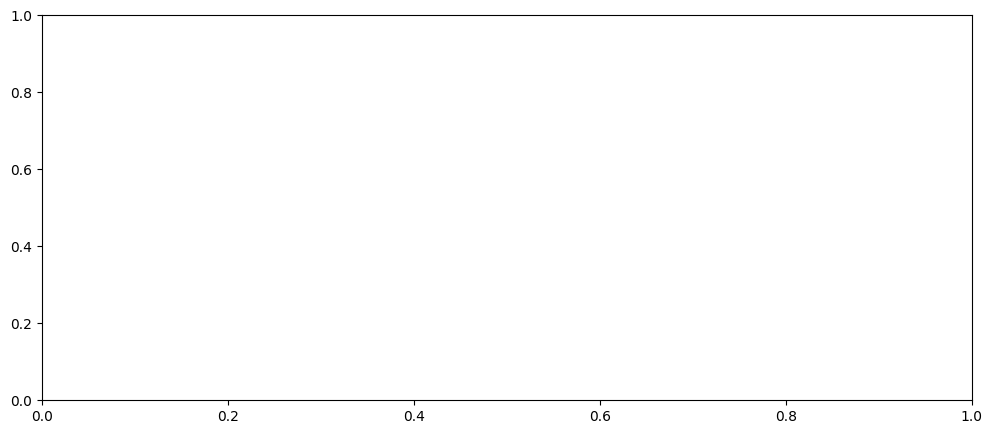

In [16]:
# --- 11. Save the Final Model (Best Fine-tuned State) ---
# The BEST_MODEL_NAME checkpoint already saves the best model based on Val EER during fine-tuning.
# We can optionally save this best model again with a different name if desired,
# but saving it as BEST_MODEL_NAME during training is sufficient.
# This step is mostly for confirming the path or saving a final state if training finished without early stopping.
final_model_filepath = os.path.join(MODEL_SAVE_PATH, FINAL_MODEL_NAME)

# Load the best model state before saving it as "final" if training stopped early
# This ensures FINAL_MODEL_NAME is truly the best state based on validation EER.
best_model_filepath_during_ft = os.path.join(MODEL_SAVE_PATH, BEST_MODEL_NAME)
if os.path.exists(best_model_filepath_during_ft):
     try:
         print(f"\nLoading best model state from {best_model_filepath_during_ft} to save as final.")
         model.load_state_dict(torch.load(best_model_filepath_during_ft, map_location=DEVICE, weights_only=True))
         torch.save(model.state_dict(), final_model_filepath)
         print(f"Final best model state saved at: {final_model_filepath}")
     except Exception as e:
         print(f"Error loading best model state for final save: {e}. Skipping final save.")
else:
    print(f"\nWarning: Best model checkpoint '{best_model_filepath_during_ft}' not found. Skipping final save.")


# --- Optional: Plot Training History (Requires matplotlib) ---
try:
    import matplotlib.pyplot as plt

    def plot_combined_history(history_initial, history_fine_tune, metric='loss'):
        """Plots a metric from both initial and fine-tuning phases."""
        plt.figure(figsize=(12, 5))
        total_epochs_initial = len(history_initial.get(metric, []))
        total_epochs_ft = len(history_fine_tune.get(metric, []))
        epochs_initial = range(1, total_epochs_initial + 1)
        if history_initial.get(metric):
            plt.plot(epochs_initial, history_initial[metric], 'bo-', label=f'Initial Training {metric.capitalize()}')
        val_metric = f'val_{metric}'
        if history_initial.get(val_metric):
            plt.plot(epochs_initial, history_initial[val_metric], 'ro-', label=f'Initial Validation {metric.capitalize()}')

        epochs_ft_total = range(total_epochs_initial + 1, total_epochs_initial + total_epochs_ft + 1)
        if history_fine_tune.get(metric):
            plt.plot(epochs_ft_total, history_fine_tune[metric], 'go-', label=f'Fine-tuning {metric.capitalize()}')
        if history_fine_tune.get(val_metric):
             plt.plot(epochs_ft_total, history_fine_tune[val_metric], 'mo-', label=f'Fine-tuning Validation {metric.capitalize()}')

        # Add plotting for eval metrics if they exist
        eval_metric = f'eval_{metric}'
        if history_initial.get(eval_metric):
             plt.plot(epochs_initial, history_initial[eval_metric], 'co--', label=f'Initial Evaluation {metric.capitalize()}')
        if history_fine_tune.get(eval_metric):
             plt.plot(epochs_ft_total, history_fine_tune[eval_metric], 'yo--', label=f'Fine-tuning Evaluation {metric.capitalize()}')


        plt.title(f'Model {metric.capitalize()} During Training')
        plt.xlabel('Epoch')
        plt.ylabel(metric.capitalize())
        handles, labels = plt.gca().get_legend_handles_labels()
        if handles: plt.legend()
        plt.grid(True)
        plt.show()

    print("\nPlotting training history...")
    if history and history_ft: # Check if histories exist
        plot_combined_history(history, history_ft, metric='loss')
        plot_combined_history(history, history_ft, metric='acc')
        plot_combined_history(history, history_ft, metric='eer')
        plot_combined_history(history, history_ft, metric='auc')
        # Plot t-DCF history from the eval set
        plot_combined_history(history, history_ft, metric='min_tdcf')
    else:
        print("Skipping plotting as one or both history objects are missing.")

except ImportError:
    print("\nMatplotlib not found. Skipping history plotting.")
except Exception as e:
    print(f"\nError during plotting: {e}")

print("\nScript finished.")

## PREDICT

In [ ]:
# --- 12. Prediction Function ---
def predict_single_audio(model, audio_path, feature_extractor, device, target_sr=TARGET_SAMPLE_RATE, max_length=MAX_LENGTH):
    """Predicts the class of a single audio file."""
    model.eval() # Set model to evaluation mode
    try:
        waveform, sample_rate = torchaudio.load(audio_path)

        # Preprocessing steps (same as in the Dataset)
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        if sample_rate != target_sr:
             waveform = torchaudio.functional.resample(waveform, orig_freq=sample_rate, new_freq=target_sr)

        if waveform.shape[1] > max_length:
            waveform = waveform[:, :max_length]

        # Process using the feature extractor
        inputs = feature_extractor(
            waveform.squeeze(0),
            sampling_rate=target_sr,
            return_tensors="pt",
            padding="max_length",
            max_length=max_length,
            truncation=True
        )

        input_values = inputs.input_values.to(device) # Move to device

        with torch.no_grad():
            with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                 logits = model(input_values)
        probabilities = torch.softmax(logits, dim=1) # Get probabilities

        # Get the predicted class (0 for spoof, 1 for bonafide)
        predicted_class = torch.argmax(probabilities, dim=1).item()

        # Get the confidence score for the predicted class
        confidence = probabilities[0, predicted_class].item()

        return predicted_class, confidence, probabilities.squeeze().cpu().numpy() # Return probabilities as numpy array

    except FileNotFoundError:
        print(f"Error: Audio file not found at {audio_path}")
        return None, None, None
    except Exception as e:
        print(f"Error processing audio file {audio_path}: {e}")
        return None, None, None

# --- Example Usage ---
print("\n--- Example Prediction ---")

# Assuming you have an example audio file path.
# Replace with a real path from your dataset or another file.
# You might need to find a specific file in your downloaded dataset structure.
# Example: Get a sample path from the eval dataframe
if not df_eval.empty:
    example_audio_path = df_eval.iloc[0]['filepath']
    print(f"Using example audio file: {example_audio_path}")

    # Assuming 'model' is the best fine-tuned model loaded previously
    # (This should be the case if the previous cells ran successfully)
    if 'model' in locals() and model is not None:
        predicted_class, confidence, probabilities = predict_single_audio(model, example_audio_path, feature_extractor, DEVICE)

        if predicted_class is not None:
            label_map = {0: "Spoof (Fake)", 1: "Bonafide (Real)"}
            predicted_label = label_map.get(predicted_class, "Unknown")

            print(f"Predicted Class: {predicted_label}")
            print(f"Confidence: {confidence:.4f}")
            print(f"Probabilities (Spoof, Bonafide): {probabilities}")
        else:
            print("Prediction failed.")
    else:
        print("Error: Model not found. Please ensure the training/fine-tuning cells ran successfully.")
else:
    print("Error: Evaluation dataframe is empty. Cannot get an example audio file.")


--- Example Prediction ---
Using example audio file: /kaggle/input/asvspoof2019-la/LA/ASVspoof2019_LA_eval/flac/LA_E_9719105.flac
Predicted Class: Spoof (Fake)
Confidence: 0.5278
Probabilities (Spoof, Bonafide): [0.528  0.4724]


In [ ]:
# --- 13. Load the Best Model and Predict ---
print("\n--- Loading Best Model and Making a Prediction ---")

# Assuming the best model was saved to BEST_MODEL_NAME in MODEL_SAVE_PATH
best_model_filepath = "/kaggle/input/wav2vec/pytorch/default/1/wav2vec2_deepfake_best.pt"

# Ensure model object exists and is on the correct device
if 'model' not in locals() or model is None:
     print("Error: Model object not found. Re-initializing model for loading.")
     model = XLSRClassificationModel(
         model_identifier=MODEL_IDENTIFIER,
     ).to(DEVICE)
     # Ensure the encoder is unfrozen if you plan to do further fine-tuning or evaluation on unfrozen layers
     # If you only need prediction, you can keep it frozen or unfreeze based on how it was trained
     # For this example, we assume the best model is from the fine-tuning stage where layers were unfrozen
     model.unfreeze_encoder(num_layers=8) # Adjust num_layers based on your fine-tuning setup
     model.to(DEVICE)


if os.path.exists(best_model_filepath):
    try:
        # Load the state dictionary
        model.load_state_dict(torch.load(best_model_filepath, map_location=DEVICE))
        print(f"Successfully loaded model from {best_model_filepath}")

        # --- User Input for Audio File Path ---
        # Replace this with the path to the audio file you want to predict
        audio_file_to_predict = "/kaggle/input/asvspoof2019-la/LA/ASVspoof2019_LA_eval/flac/LA_E_6262749.flac" # Example path

        print(f"Using audio file for prediction: {audio_file_to_predict}")

        if os.path.exists(audio_file_to_predict):
            predicted_class, confidence, probabilities = predict_single_audio(model, audio_file_to_predict, feature_extractor, DEVICE)

            if predicted_class is not None:
                label_map = {0: "Spoof (Fake)", 1: "Bonafide (Real)"}
                predicted_label = label_map.get(predicted_class, "Unknown")

                print(f"Predicted Class: {predicted_label}")
                print(f"Confidence: {confidence:.4f}")
                print(f"Probabilities (Spoof, Bonafide): {probabilities}")
            else:
                print("Prediction failed for the specified audio file.")
        else:
            print(f"Error: Audio file not found at {audio_file_to_predict}. Please check the path.")


    except Exception as e:
        print(f"Error loading model state dictionary or making prediction: {e}")
else:
    print(f"Error: Best model file not found at {best_model_filepath}. Please ensure training completed successfully.")


--- Loading Best Model and Making a Prediction ---


/tmp/ipykernel_31/3743744542.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_filepath, map_location=DEVICE))


Successfully loaded model from /kaggle/input/wav2vec/pytorch/default/1/wav2vec2_deepfake_best.pt
Using audio file for prediction: /kaggle/input/test-lll/20251031_hello_my_n.flac
Predicted Class: Bonafide (Real)
Confidence: 0.7944
Probabilities (Spoof, Bonafide): [0.2056 0.7944]


In [ ]:
# --- 10. Final Evaluation ---
print("\n--- Final Evaluation (Best Fine-tuned Model) ---")

# --- User Input for Model File Path to Evaluate ---
# REPLACE THIS with the actual path to the model file you want to evaluate (.pt or .pth)
# If you want to evaluate the best model saved during the fine-tuning, use BEST_MODEL_NAME.
# If you want to evaluate the final saved model, use FINAL_MODEL_NAME.
# If you want to evaluate a different model, provide its full path.
model_file_to_evaluate = "/kaggle/input/xlsr/pytorch/default/1/xlsr_initial_best.pt" # Default to best fine-tuned model

print(f"Attempting to evaluate model from: {model_file_to_evaluate}")

# Re-initialize the model architecture to match the saved state_dict
# This assumes the same model class (XLSRClassificationModel) and parameters (MODEL_IDENTIFIER)
try:
    # Assuming XLSRClassificationModel and MODEL_IDENTIFIER are defined in previous cells
    model_for_evaluation = XLSRClassificationModel(
        model_identifier=MODEL_IDENTIFIER,
    ).to(DEVICE)
    # Unfreeze layers as needed based on how the saved model was trained
    # For this example, we assume it was fine-tuned with 8 layers unfrozen
    model_for_evaluation.unfreeze_encoder(num_layers=8)
    model_for_evaluation.to(DEVICE)
    print("Model architecture initialized for loading.")
except NameError:
    print("Error: XLSRClassificationModel or MODEL_IDENTIFIER not defined. Please run previous cells.")
    model_for_evaluation = None
except Exception as e:
    print(f"Error initializing model architecture for loading: {e}")
    model_for_evaluation = None


if model_for_evaluation is not None and os.path.exists(model_file_to_evaluate):
    try:
        # Load the state dictionary
        # Use map_location to ensure it loads correctly onto the current device (CPU or GPU)
        # Use weights_only=True for safety in future PyTorch versions
        model_for_evaluation.load_state_dict(torch.load(model_file_to_evaluate, map_location=DEVICE, weights_only=True))
        print(f"Successfully loaded model state dictionary from {model_file_to_evaluate}")

        # --- Evaluate the Loaded Model ---
        print("\n--- Evaluating the Loaded Model ---")
        # Assuming dev_loader, eval_loader, criterion, and DEVICE are defined in previous cells
        if ('dev_loader' in locals() and dev_loader is not None and
            'eval_loader' in locals() and eval_loader is not None and
            'criterion' in locals() and criterion is not None):

             print("\nEvaluating on Development Set:")
             # Unpack 4 values including AUC
             dev_loss, dev_acc, dev_eer, dev_auc = evaluate(model_for_evaluation, dev_loader, criterion, DEVICE)
             print(f"Dev Loss: {dev_loss:.4f}, Dev Acc: {dev_acc:.4f}, Dev EER: {dev_eer:.4f}, Dev AUC: {dev_auc:.4f}")

             print("\nEvaluating on Evaluation Set:")
             # Unpack 4 values including AUC
             eval_loss, eval_acc, eval_eer, eval_auc = evaluate(model_for_evaluation, eval_loader, criterion, DEVICE)
             print(f"Eval Loss: {eval_loss:.4f}, Eval Acc: {eval_acc:.4f}, Eval EER: {eval_eer:.4f}, Eval AUC: {eval_auc:.4f}")

             # Optional: Generate Classification Report
             if 'generate_report' in locals():
                 generate_report(model_for_evaluation, dev_loader, DEVICE, "Loaded Model Dev")
                 generate_report(model_for_evaluation, eval_loader, DEVICE, "Loaded Model Eval")
             else:
                  print("Warning: generate_report function not found. Skipping classification reports.")


        else:
            print("Error: Data loaders or criterion are not defined or are None. Cannot perform evaluation.")


    except Exception as e:
        print(f"Error loading model state dictionary or during evaluation: {e}")
else:
    if model_for_evaluation is None:
        print("Error: Model architecture could not be initialized. Cannot load state dict.")
    elif not os.path.exists(model_file_to_evaluate):
        print(f"Error: Model file not found at {model_file_to_evaluate}. Please check the path.")
    else:
        print("An unknown error occurred during model loading or evaluation setup.")

# Remove model_for_evaluation to free up memory if needed
# del model_for_evaluation
# if DEVICE.type == 'cuda': torch.cuda.empty_cache()


--- Final Evaluation (Best Fine-tuned Model) ---
Attempting to evaluate model from: /kaggle/input/xlsr/pytorch/default/1/xlsr_initial_best.pt
Loading pre-trained model: facebook/wav2vec2-xls-r-300m
Freezing encoder layers...
Encoder layers frozen.
Model hidden size: 1024
Unfreezing the top 8 encoder layers...
Model architecture initialized for loading.


/tmp/ipykernel_31/3875062183.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_for_evaluation.load_state_dict(torch.load(model_file_to_evaluate, map_location=DEVICE

Successfully loaded model state dictionary from /kaggle/input/xlsr/pytorch/default/1/xlsr_initial_best.pt

--- Evaluating the Loaded Model ---

Evaluating on Development Set:


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]


--- Evaluation Batch 0 Diagnostics ---
Labels (first 10): [0 1 1 0 0 1 0 0 1 0]
Logits (first 5): 
[[-0.4875  0.933 ]
 [-1.053   1.531 ]
 [-1.298   1.723 ]
 [-0.68    1.116 ]
 [-0.689   1.119 ]]
Probabilities (first 5): 
[[0.1946 0.8057]
 [0.0702 0.9297]
 [0.0465 0.9536]
 [0.1423 0.858 ]
 [0.1409 0.8594]]
Positive Class Probs (first 10): [0.8057 0.9297 0.9536 0.858  0.8594 0.9194 0.8857 0.223  0.964  0.809 ]
Predicted Binary (first 10): [1 1 1 1 1 1 1 0 1 1]
--- End Diagnostics ---
Error loading model state dictionary or during evaluation: not enough values to unpack (expected 4, got 3)
